# Telecom Customer Churn Prediction
The Customer Churn dataset contains information on all 7,043 customers from a Telecommunications company in California in Q2 2022.

---



I will evaluate the performance of the machine learning model on the dataset both with and without applying Principal Component Analysis (PCA) to understand the impact of dimensionality reduction on the model’s accuracy and computational efficiency.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA

from time import perf_counter

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr
data = pd.read_csv("/content/telecom_customer_churn.csv")
data

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr
To: /content/telecom_customer_churn.csv
100% 1.44M/1.44M [00:00<00:00, 71.7MB/s]


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


This dataset has 7043 records of customers and 37 features. Customer status is the target.

Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!

In [ ]:
# data.describe(include='all').T

In [ ]:
print(data.shape)
print(data.dtypes)
print(data.info())

(7043, 38)
Customer ID                           object
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object

In [ ]:
data = data.drop(['Customer ID', 'City', 'Zip Code', 'Churn Category', 'Churn Reason'], axis=1)

In [ ]:
data.duplicated().sum()

0

# Visualization of nominal features

In [ ]:
df1 = data.select_dtypes(exclude='number')

In [ ]:
df1.describe().T

,count,unique,top,freq
Gender,7043,2,Male,3555
Married,7043,2,No,3641
Offer,7043,6,None,3877
Phone Service,7043,2,Yes,6361
Multiple Lines,6361,2,No,3390
Internet Service,7043,2,Yes,5517
Internet Type,5517,3,Fiber Optic,3035
Online Security,5517,2,No,3498
Online Backup,5517,2,No,3088
Device Protection Plan,5517,2,No,3095


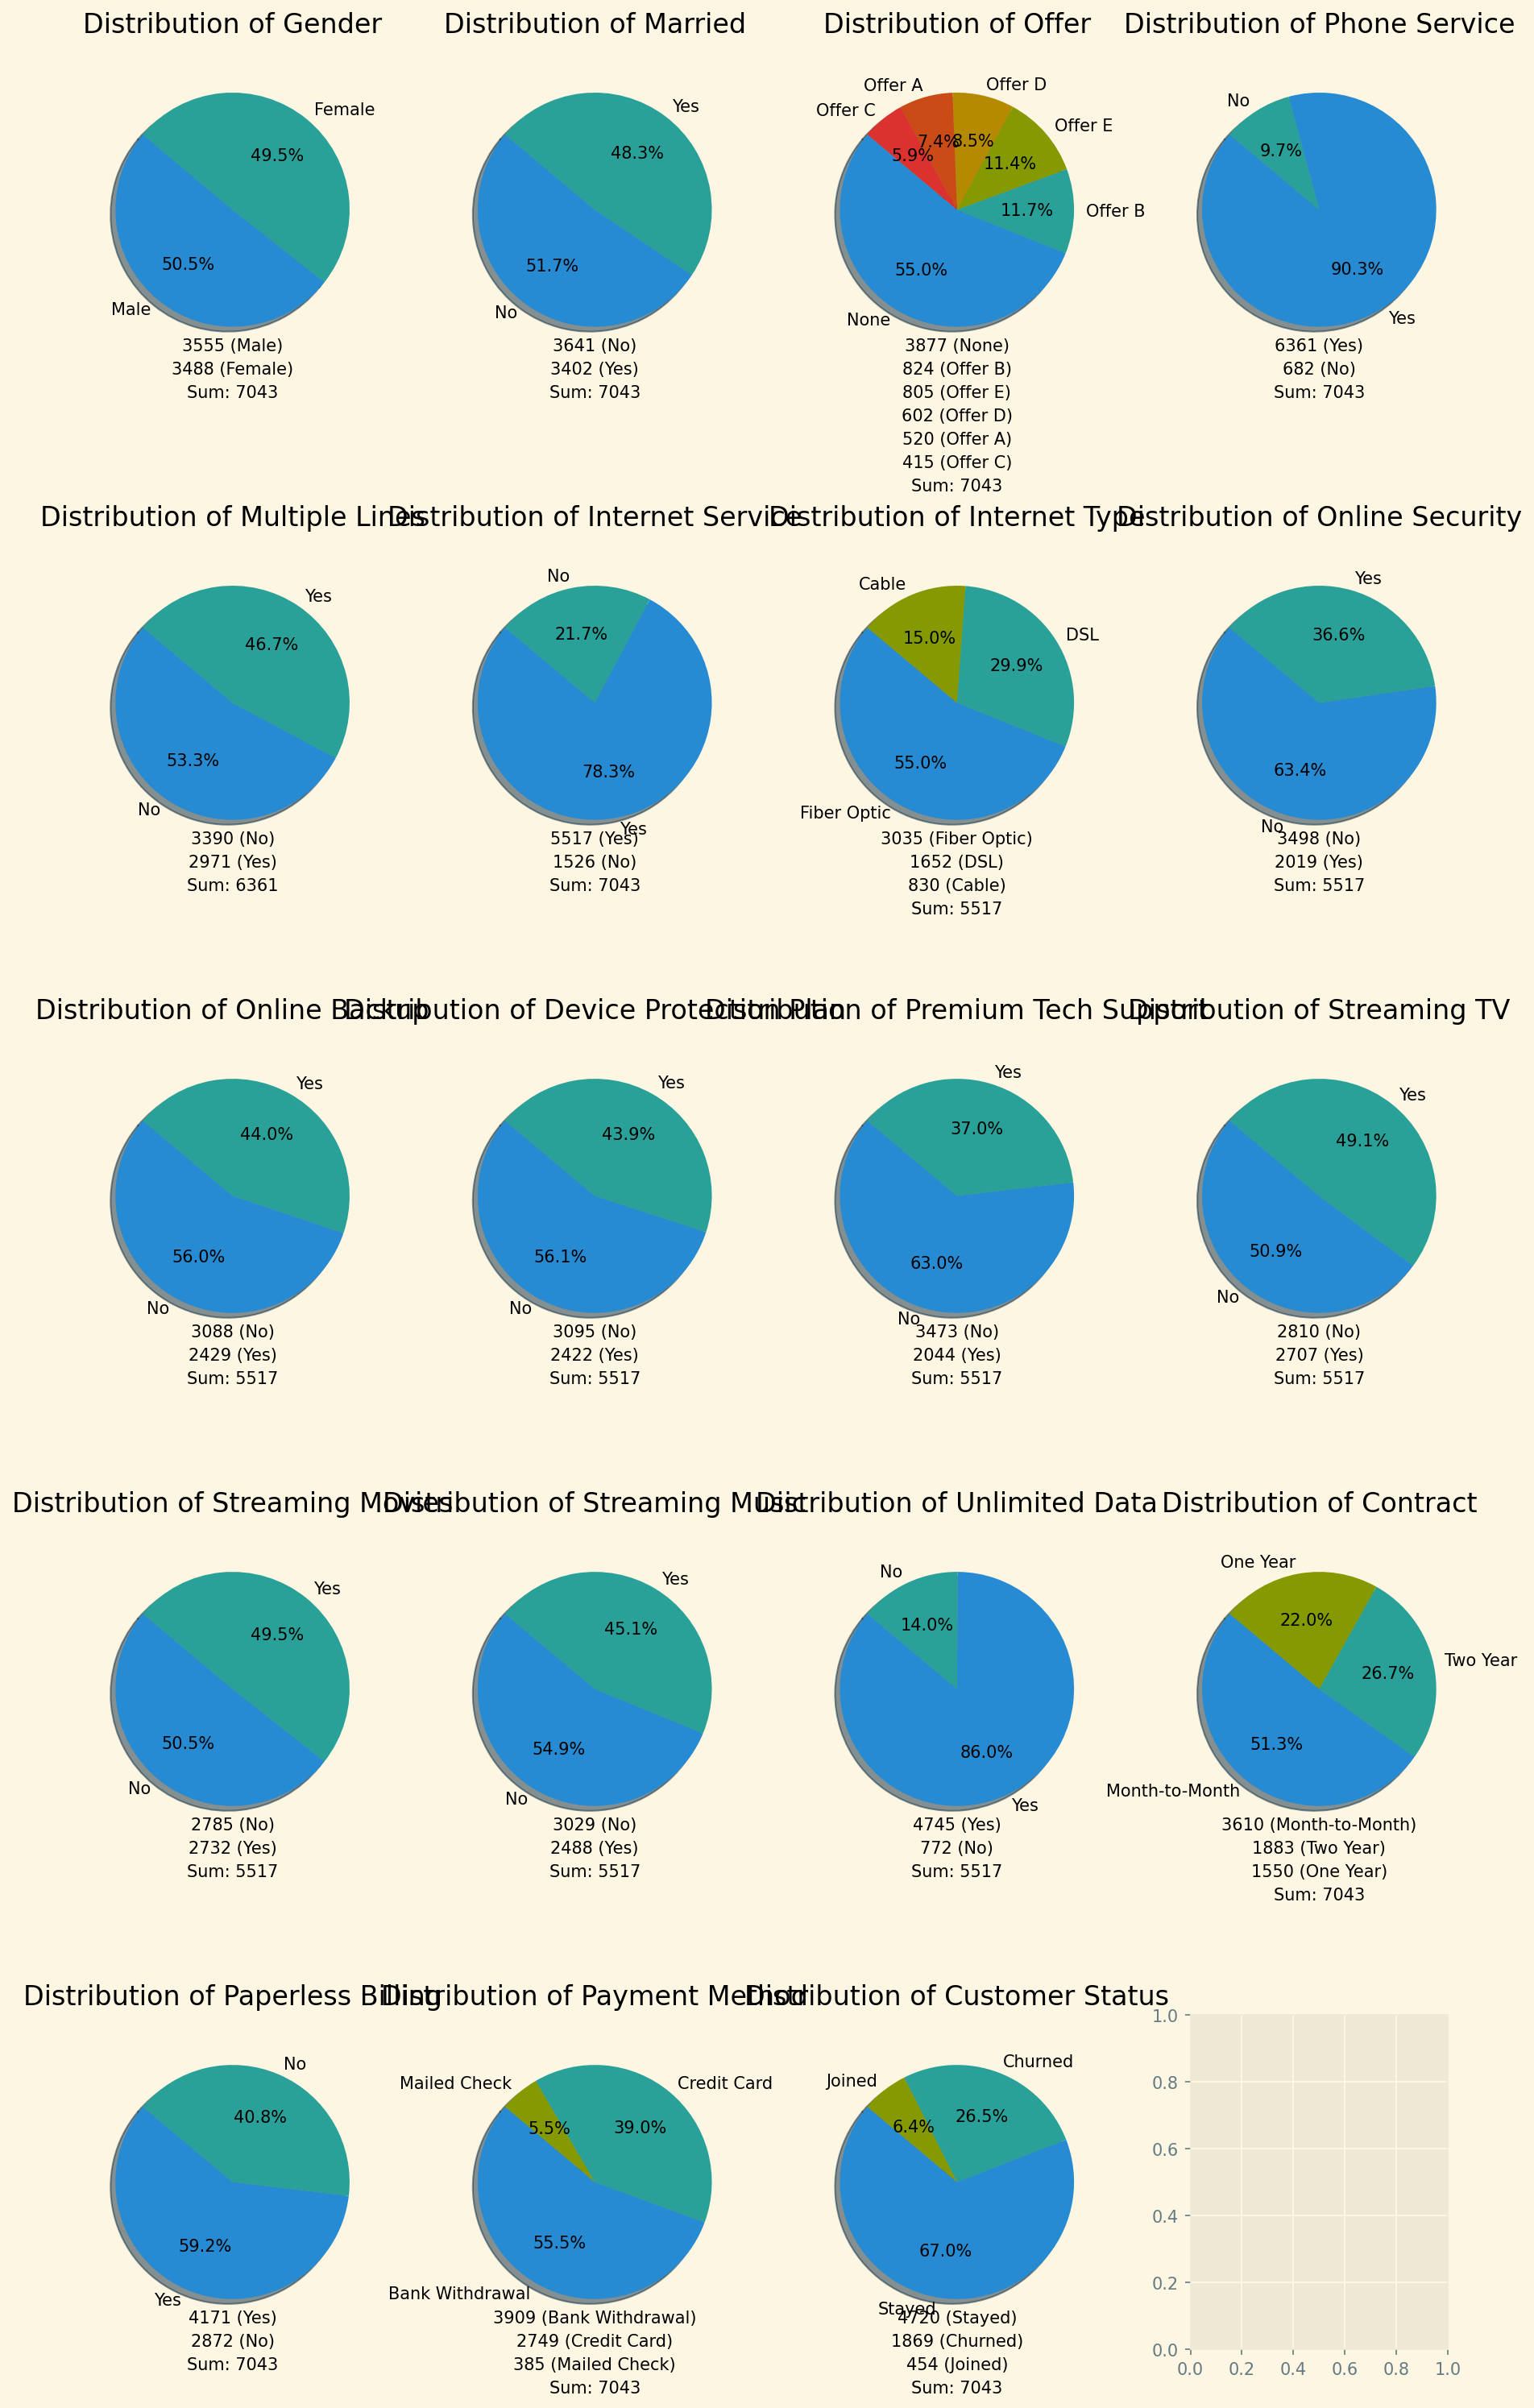

In [ ]:
# Plotting the pie chart
num_rows = 5
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

for i, column in enumerate(df1.columns):
    categories = df1[column].value_counts()

    ax = axes[i // num_cols, i % num_cols]

    ax.pie(categories, labels=categories.index, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')
    ax.set_title(f'Distribution of {column}')

    # Add text annotations for value count and sum
    total = categories.values.sum()
    sum_text = f'Sum: {total}'
    ax.text(0, -1.2 - len(categories)*0.2, sum_text, ha='center')

    for j, percentage in enumerate(categories):
        percent_text = f'{percentage} ({categories.index[j]})'
        ax.text(0, -1.2 - j*0.2, percent_text, ha='center')

plt.tight_layout()
plt.show()

# Filling null values in nominal features

null values in nominal features:
Gender                       0
Married                      0
Offer                        0
Phone Service                0
Multiple Lines             682
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
Customer Status              0
dtype: int64


<Axes: >

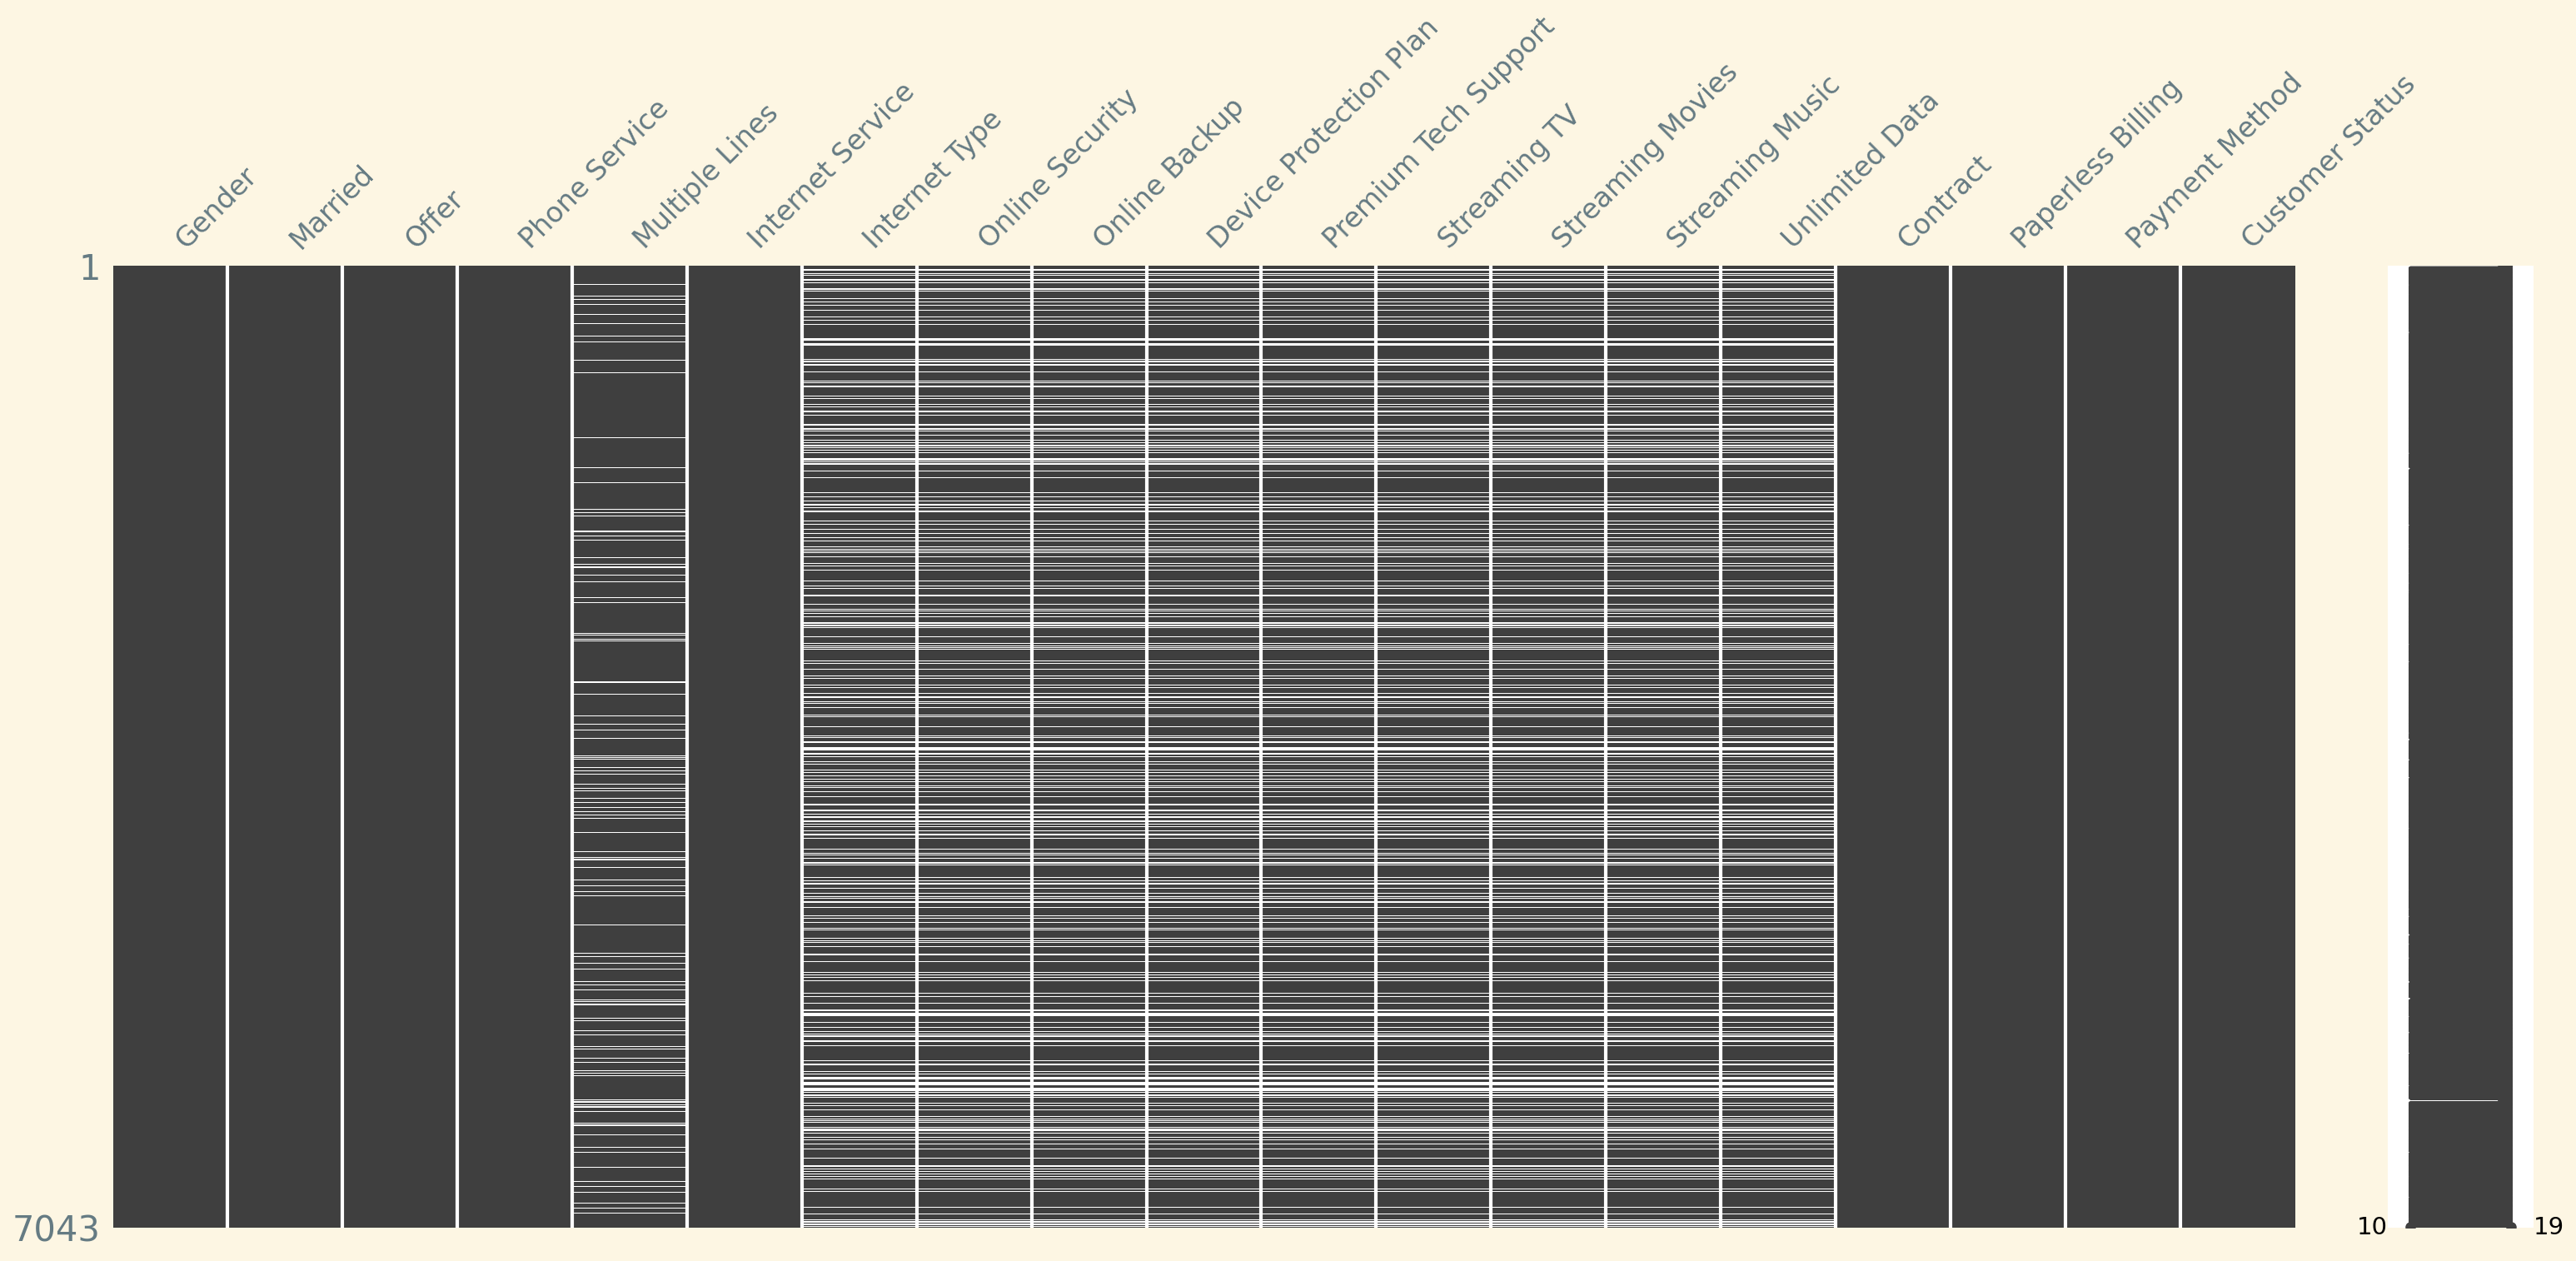

In [ ]:
#checking null values
print(f"null values in nominal features:\n{df1.isna().sum()}")
msno.matrix(df1)

Internet service shows indicates if the customer subscribes to Internet service with the company: Yes, No.

Sum of customer that subscribe internet services are 5517.

According above visualization, some features are dependent on internet service. In other words, these features can be activated when the customer subscribes to Internet service.


*   Internet Type
*   Online Security
*   Online Backup
*   Device Protection Plan
*   Premium Tech Support
*   Streaming TV
*   Streaming Movies
*   Streaming Music
*   Unlimited Data

According to the above results, we can see customers who don't subscribe to internet services, have null values in the mentioned features. Consequently, for cleaning these features, the null value of these columns should take "No" values.

In [ ]:
#filling null values
df1['Internet Type'] = df1['Internet Type'].apply(lambda x: 'None' if pd.isnull(x) else x)

column_name = ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
               'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']
for column in column_name:
  df1[column] = df1[column].apply(lambda x: 'No' if pd.isnull(x) else x)

<Axes: >

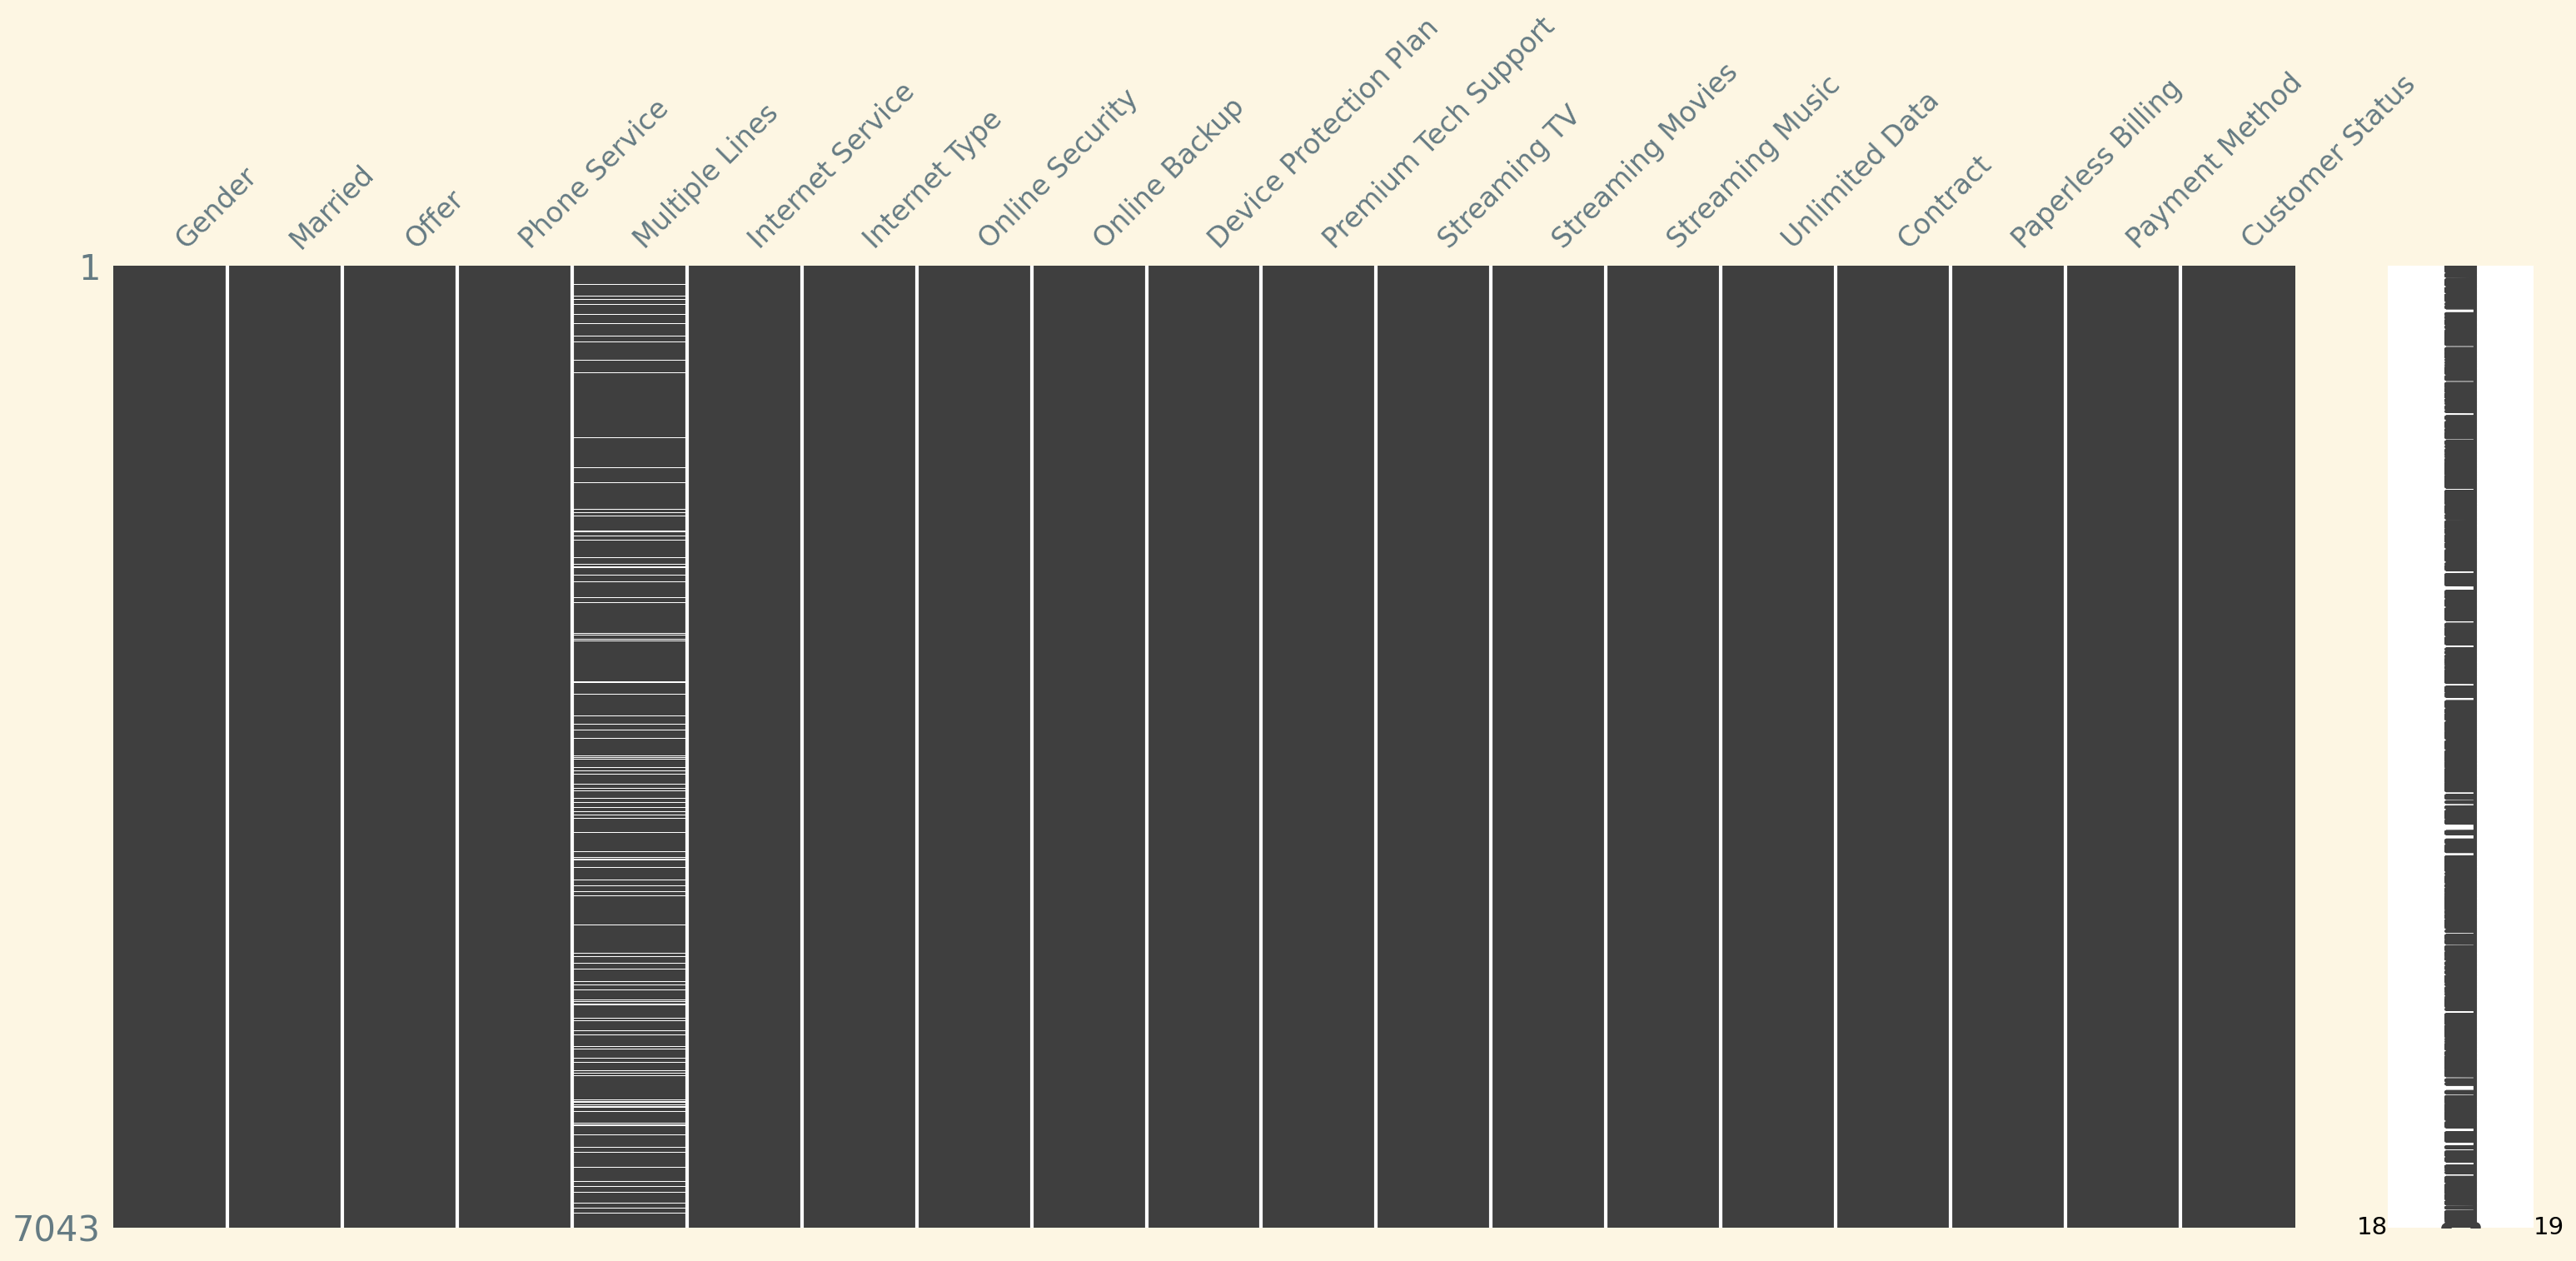

In [ ]:
msno.matrix(df1)

I decide to fill missing value in the Multiple Line feature by KNN imputer.

before applying KNN imputer, the dataset should be labeled.


---

## Label Encoding


In [ ]:
# first step:
conversion_dict = {"Yes": 1, "No": 0}
df1['Multiple Lines'] = df1['Multiple Lines'].map(conversion_dict)

# second step: labeling the target by using LabelEncoder
label_encoder = LabelEncoder()
df1['Customer Status'] = label_encoder.fit_transform(df1['Customer Status'])

# third step: using pd.get_dummies for other features
df1 = pd.get_dummies(df1, drop_first=True)

In [ ]:
# the KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(df1)
imputed_data = np.round(imputed_data)
# If we want to keep the DataFrame format:
df1_imputed = pd.DataFrame(data=imputed_data, columns=df1.columns)

0.0    3806
1.0    3237
Name: Multiple Lines, dtype: int64

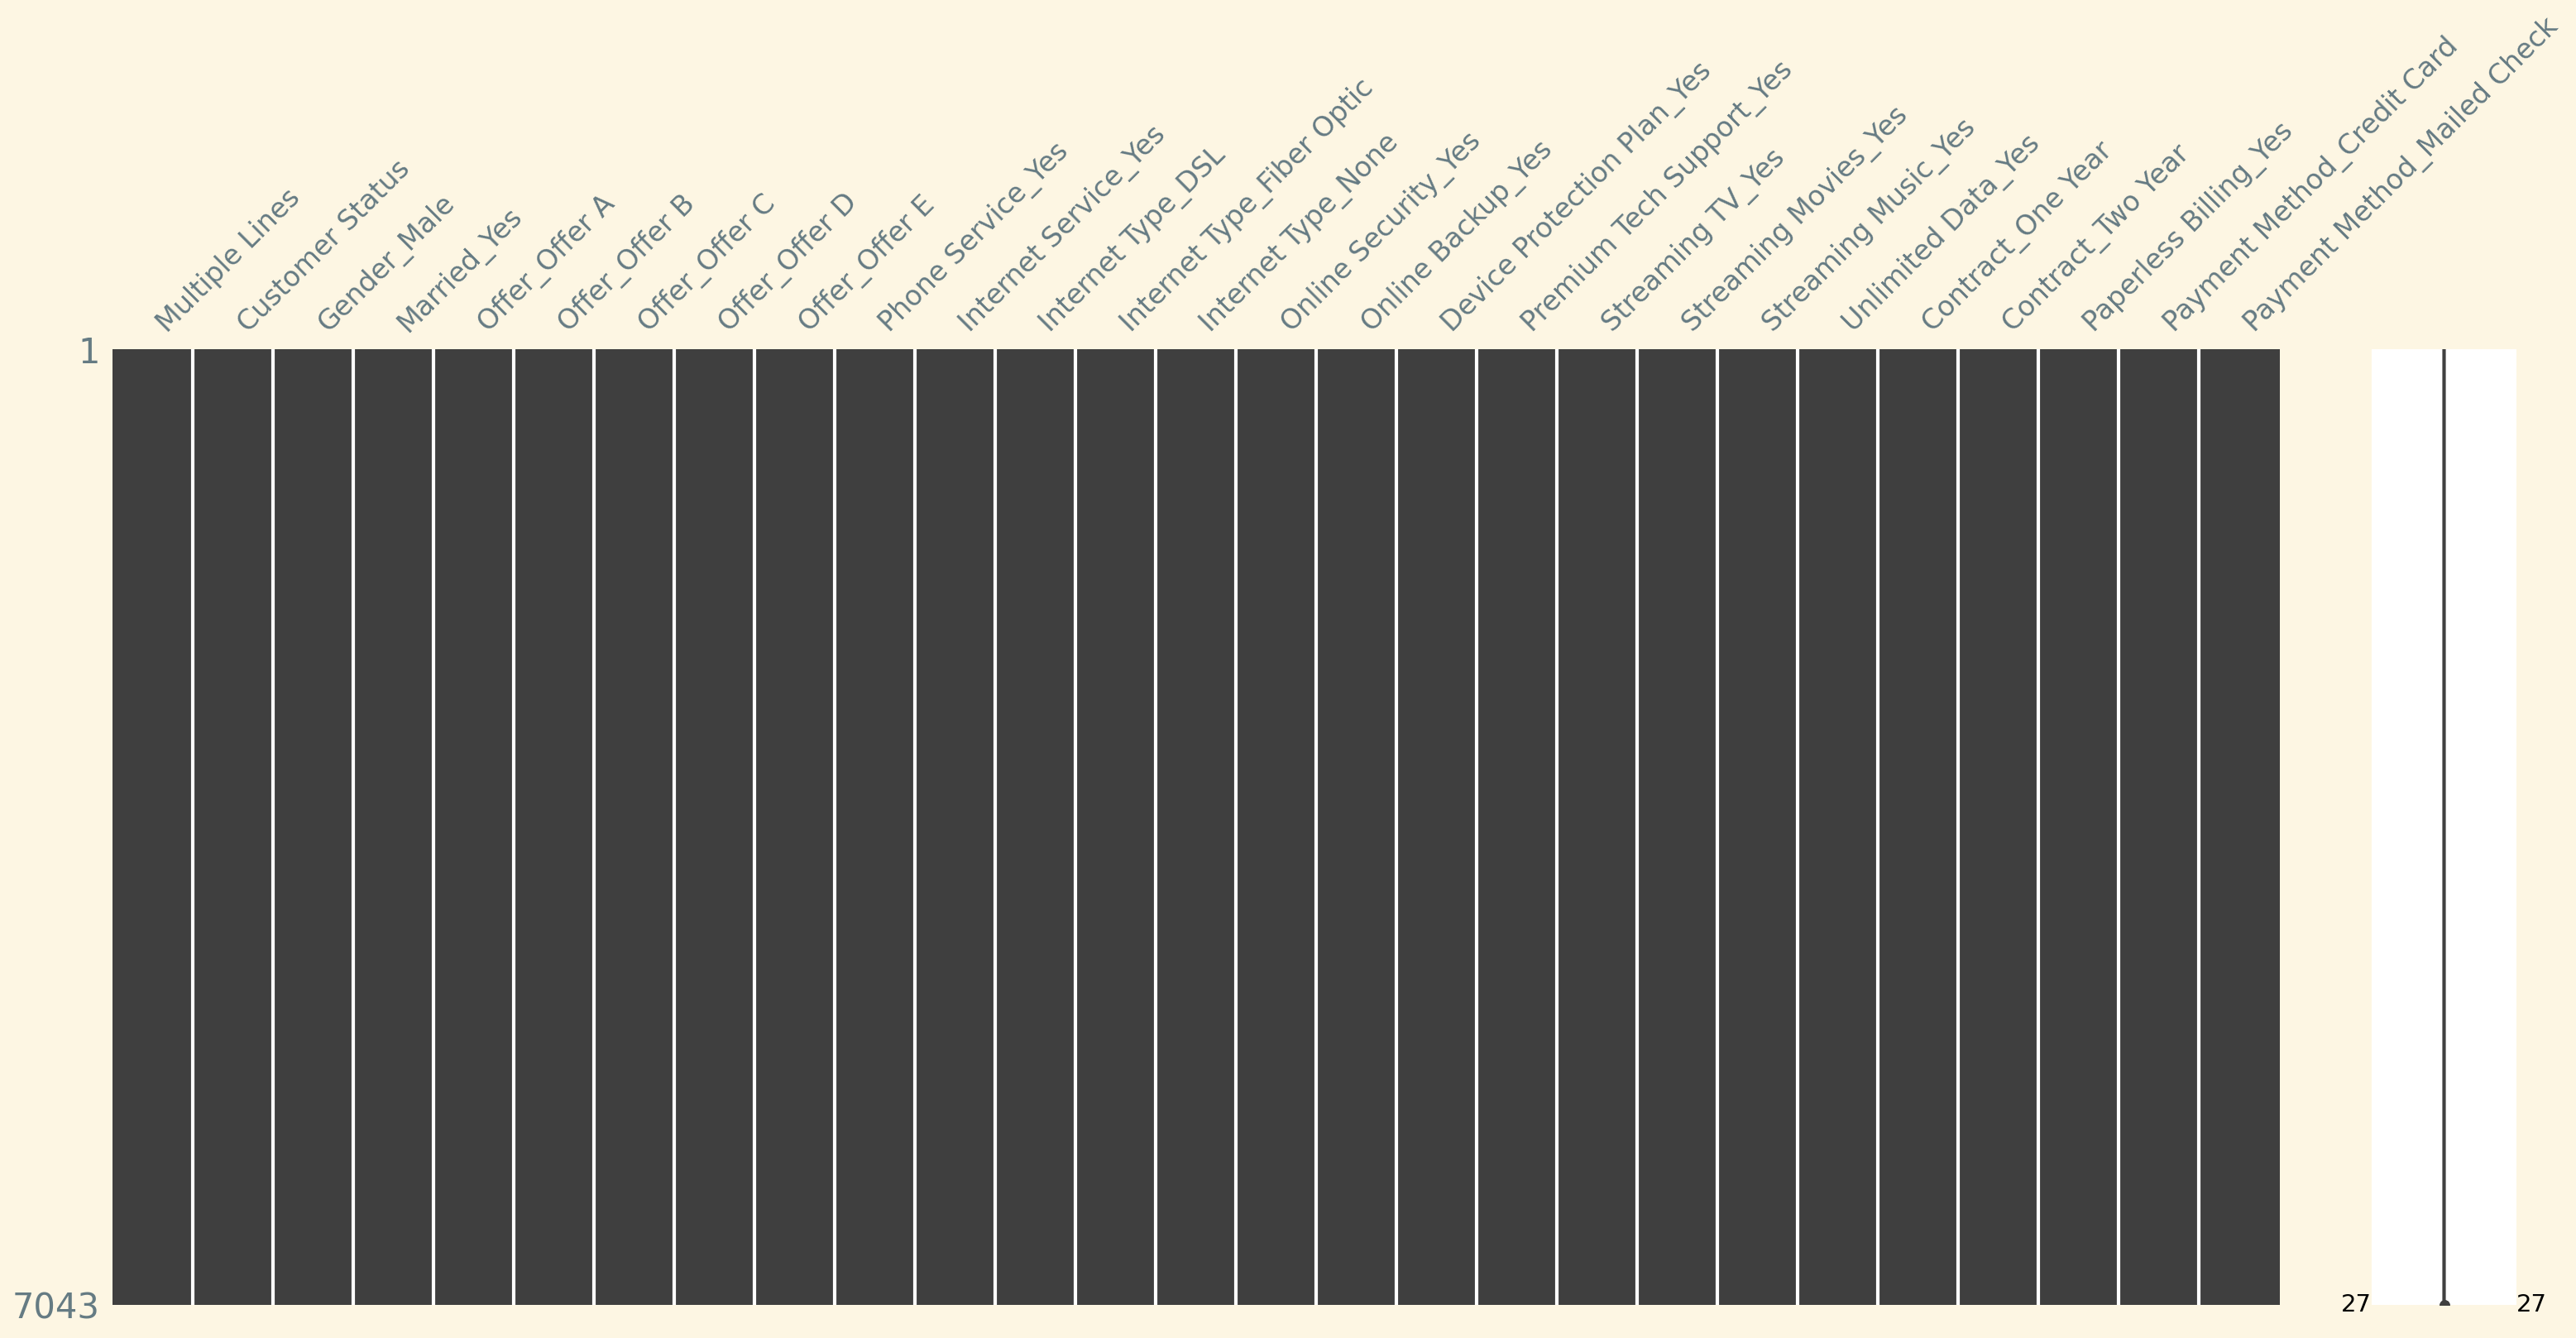

In [ ]:
# checking missing value
msno.matrix(df1_imputed)
df1_imputed['Multiple Lines'].value_counts()

# Visualization of numerical features

In [ ]:
df2 = data.select_dtypes(include='number')

In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
Number of Referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
Tenure in Months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
Avg Monthly Long Distance Charges,6361.0,25.420517,14.200374,1.010000,13.050000,25.690000,37.680000,49.990000
Avg Monthly GB Download,5517.0,26.189958,19.586585,2.000000,13.000000,21.000000,30.000000,85.000000
Monthly Charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000
Total Charges,7043.0,2280.381264,2266.220462,18.800000,400.150000,1394.550000,3786.600000,8684.800000


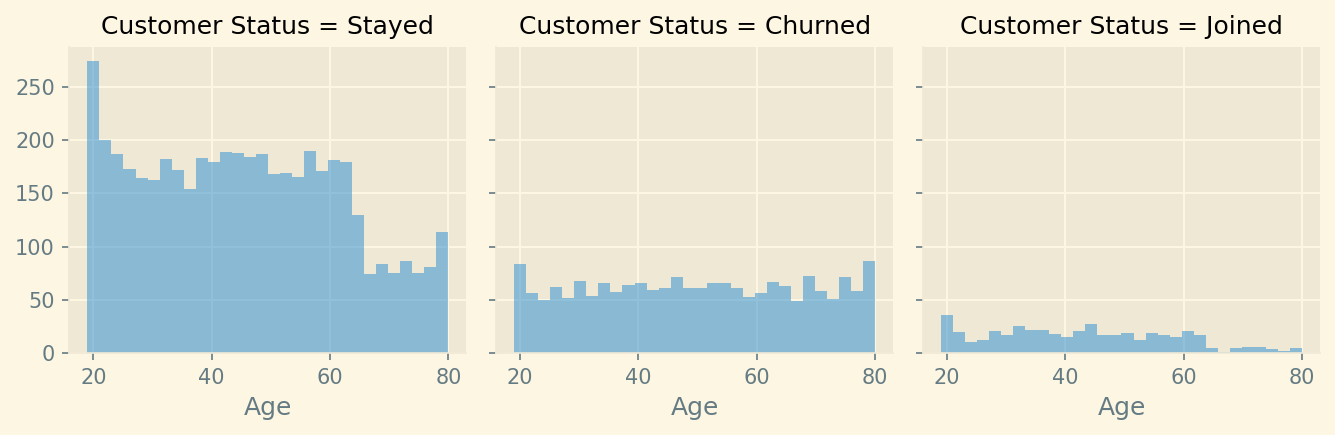

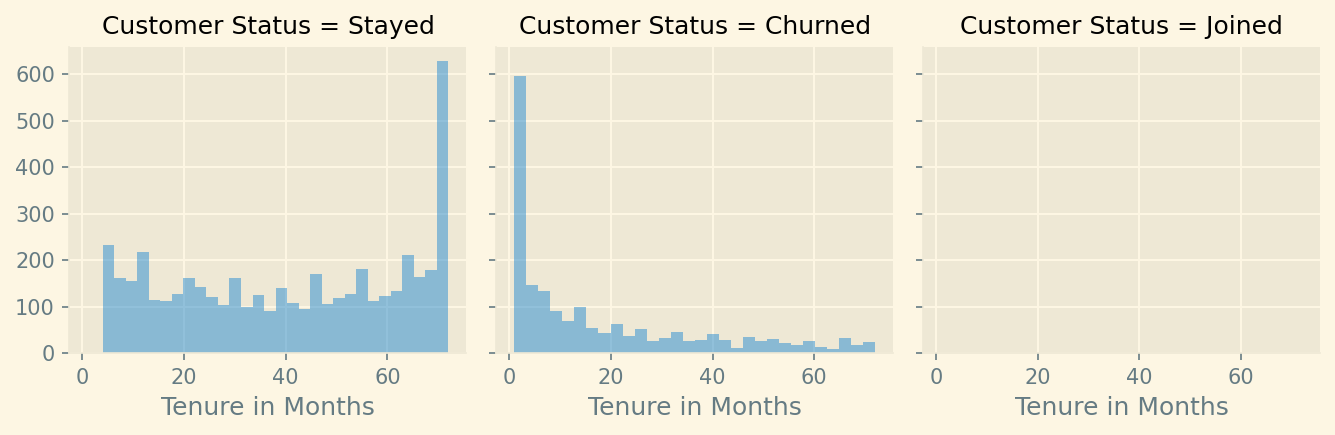

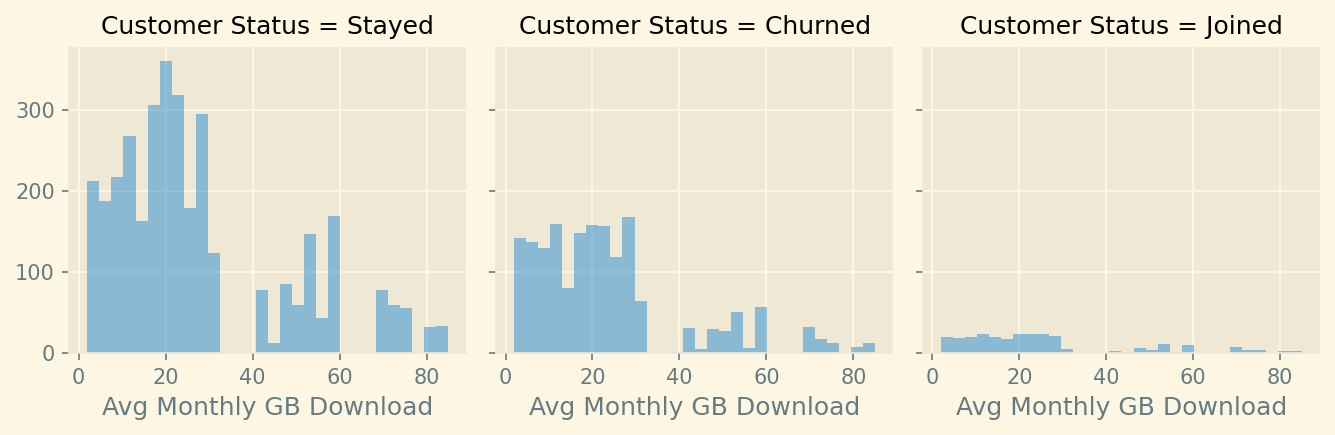

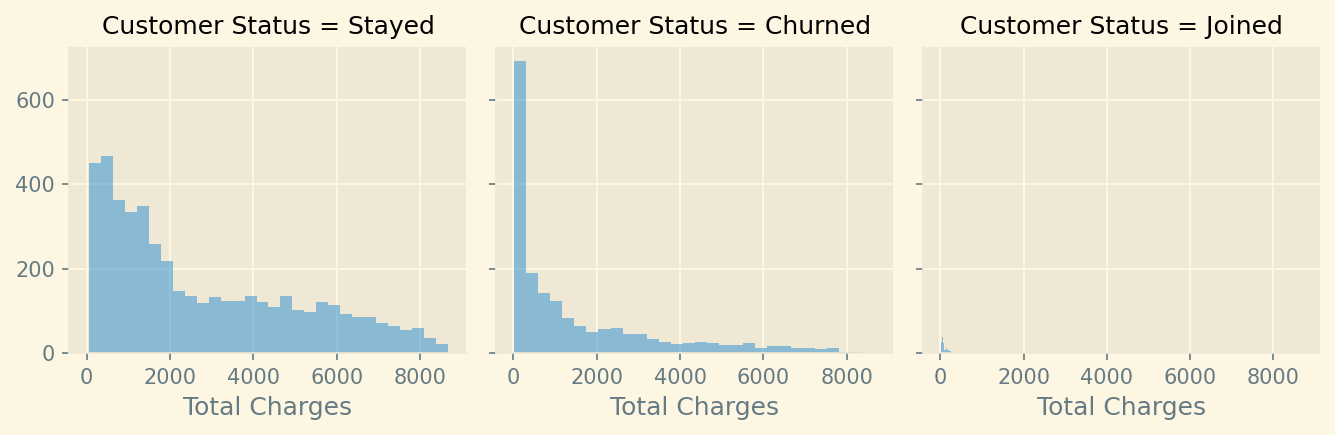

In [ ]:
# Visualization
column_name = ['Age', 'Tenure in Months', 'Avg Monthly GB Download', 'Total Charges']
for column in column_name:
  v = sns.FacetGrid(data, col='Customer Status')
  v.map(plt.hist, column, alpha=0.5, bins=30)
  plt.show

In [ ]:
# visualization
'''
column_name = [
    #'Age',
    'Total Charges']
indices_name = ['Gender', 'Married', 'Offer', 'Phone Service', 'Internet Service', 'Contract', 'Payment Method']
for column in column_name:
    for k in indices_name:
      v = sns.FacetGrid(data, col='Customer Status', row=k, margin_titles=True)
      v.map(plt.hist, column, alpha=0.5, bins=30)
      plt.show
'''

"\ncolumn_name = [\n    #'Age',\n    'Total Charges']\nindices_name = ['Gender', 'Married', 'Offer', 'Phone Service', 'Internet Service', 'Contract', 'Payment Method']\nfor column in column_name:\n    for k in indices_name:\n      v = sns.FacetGrid(data, col='Customer Status', row=k, margin_titles=True)\n      v.map(plt.hist, column, alpha=0.5, bins=30)\n      plt.show\n"

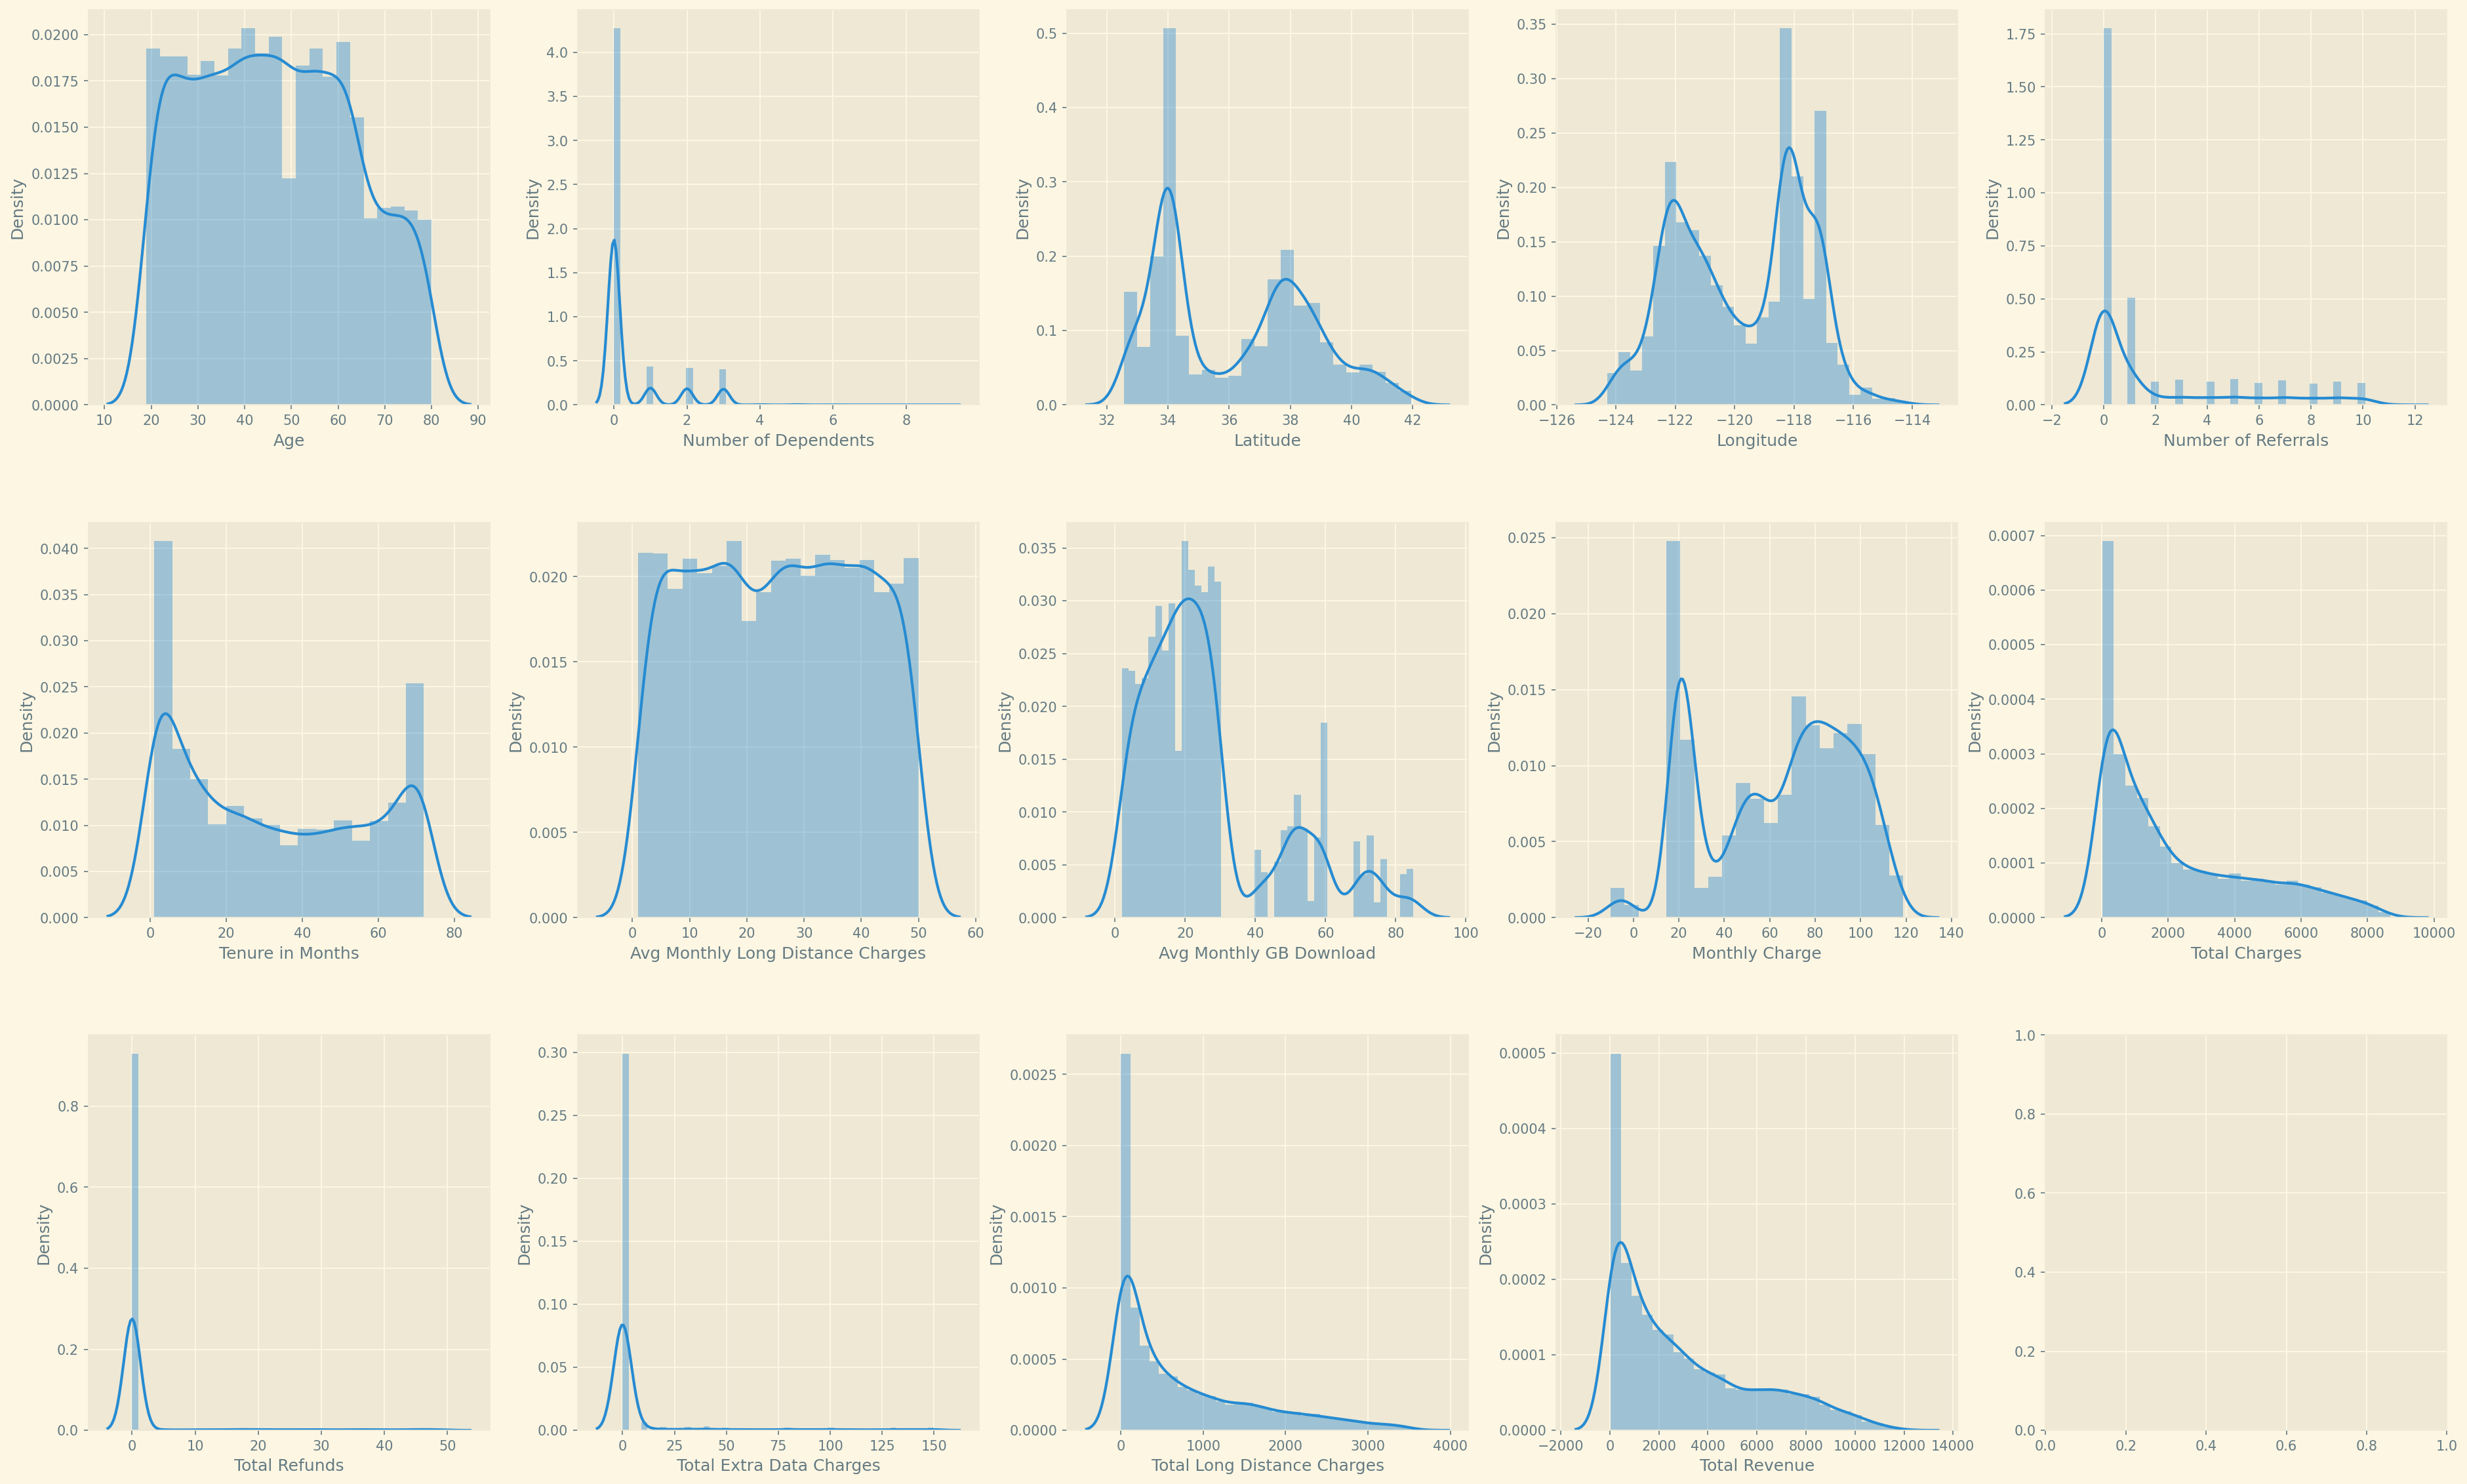

In [ ]:
# visualization: distribution plot
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(25,15))
index = 0
axs = axs.flatten()
for k, v in df2.items():
  sns.distplot(v, ax=axs[index])
  index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5)

Age                                      Avg Monthly GB Download
Number of Dependents                     Avg Monthly GB Download
Latitude                                               Longitude
Longitude                                               Latitude
Number of Referrals                             Tenure in Months
Tenure in Months                                   Total Revenue
Avg Monthly Long Distance Charges    Total Long Distance Charges
Avg Monthly GB Download                                      Age
Monthly Charge                                     Total Charges
Total Charges                                      Total Revenue
Total Refunds                                   Tenure in Months
Total Extra Data Charges                           Total Revenue
Total Long Distance Charges                        Total Revenue
Total Revenue                                      Total Charges
dtype: object

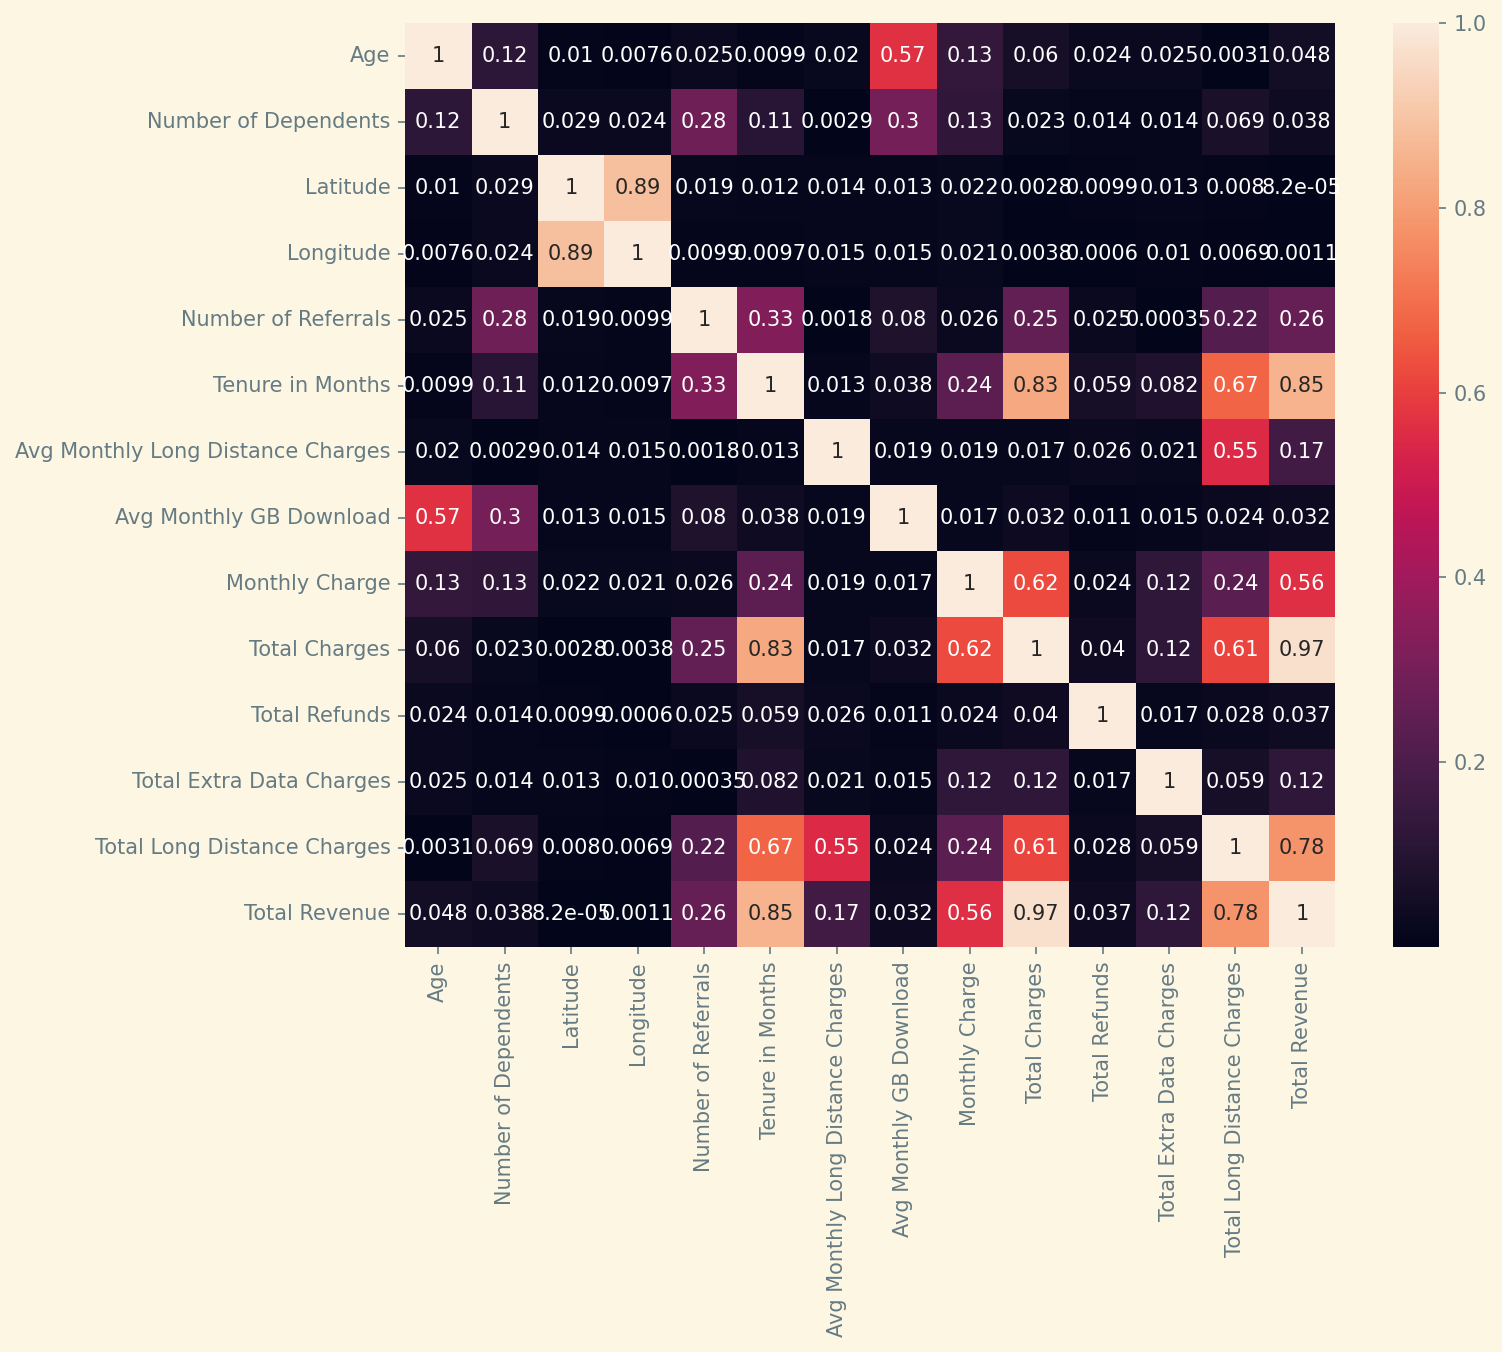

In [ ]:
#heat map
corr_mat = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat.abs(), annot=True)

for x in range(len(df2.columns)):
  corr_mat.iloc[x,x] = 0.0
corr_mat.abs().idxmax()

Because **Total Charges** and **Total Revenue** have a high correlation, we can drop one of them.

In [ ]:
df2 = df2.drop(['Total Revenue'],axis=1)

# Filling null values in numerical features

null values in numerical features:
 Age                                     0
Number of Dependents                    0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Avg Monthly Long Distance Charges     682
Avg Monthly GB Download              1526
Monthly Charge                          0
Total Charges                           0
Total Refunds                           0
Total Extra Data Charges                0
Total Long Distance Charges             0
dtype: int64


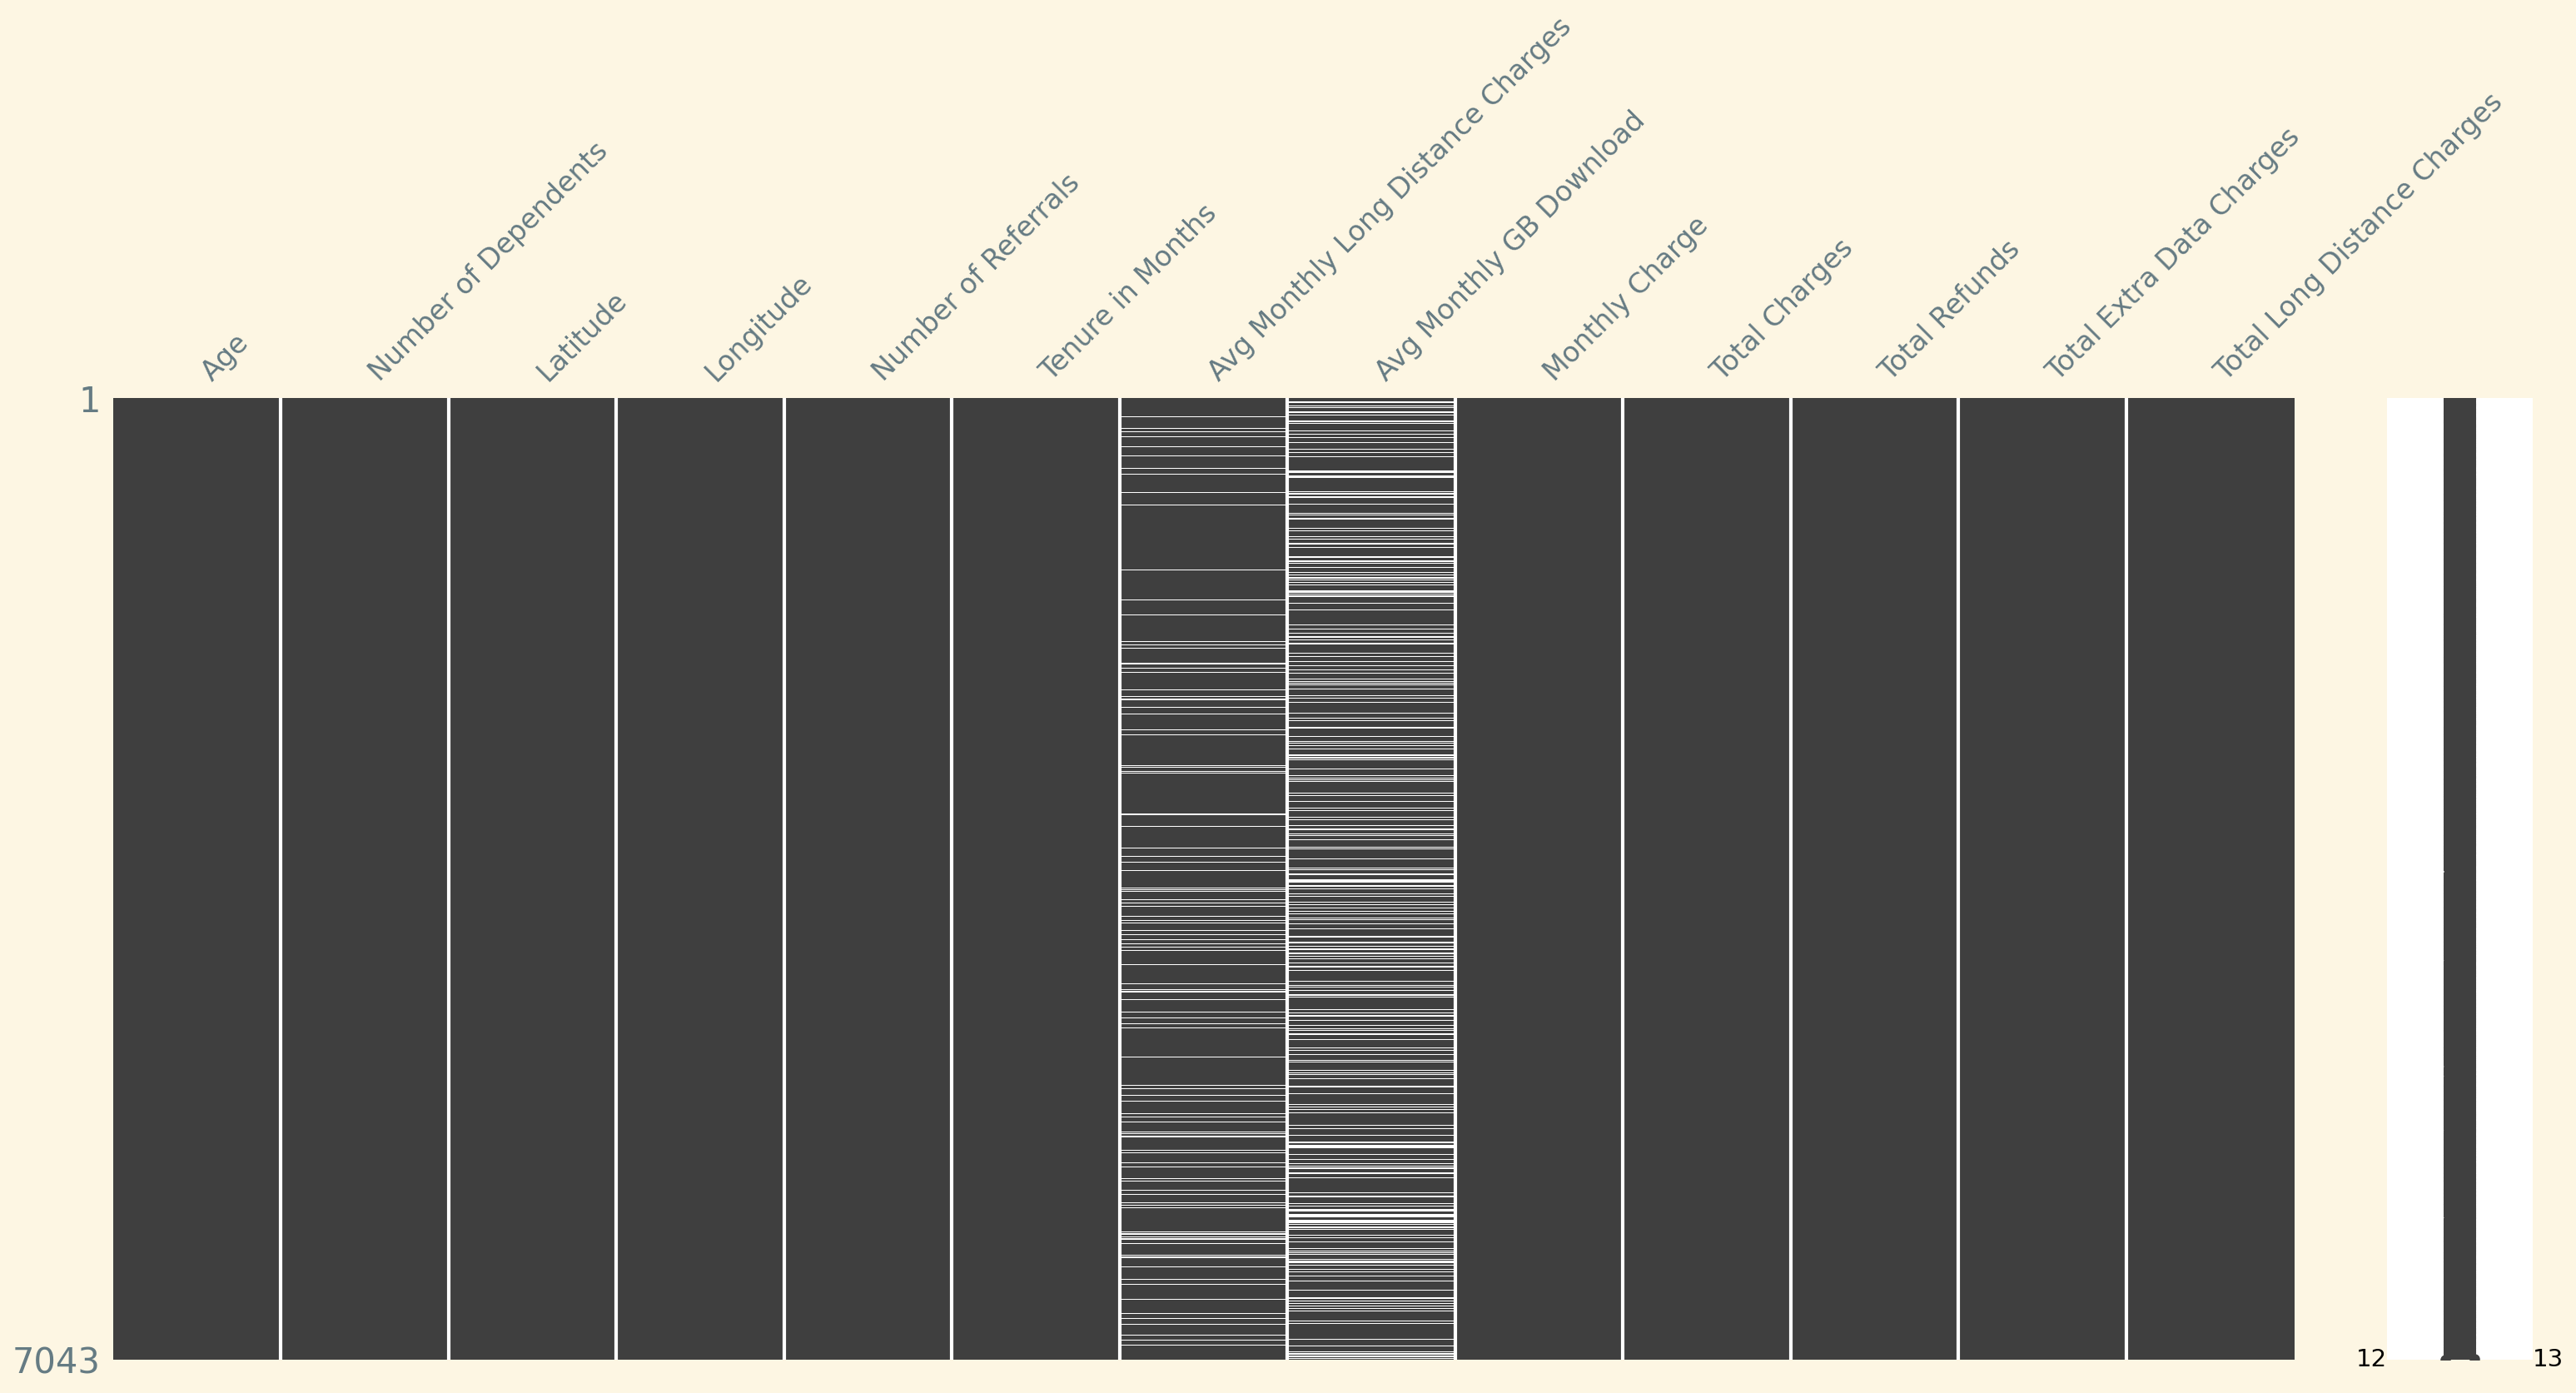

In [ ]:
msno.matrix(df2)
print("null values in numerical features:\n",df2.isna().sum())

Internet service shows indicates if the customer subscribes to Internet service with the company: Yes, No.

Sum of customer that subscribe internet services are 5517.

According above visualization, ***Avg Monthly GB Download*** feature is dependent on internet service. In other words, this feature can be activated when the customer subscribes to Internet service.


Thus, we can see customers who don't subscribe to internet services, have null values in the mentioned feature. Consequently, for cleaning this features, the null value of this column should take ***0*** values.


---

According to the information about this dataset in kaggle, ***Avg Monthly Long Distance Charges*** Indicates the customer's average long distance charges, calculated to the end of the quarter specified above (if the customer is not subscribed to home phone service, this will be 0)

In [ ]:
#filling null values
column_name = ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']
for column in column_name:
  df2[column] = df2[column].apply(lambda x: 0 if pd.isnull(x) else x)

null values in numerical features:
 Age                                  0
Number of Dependents                 0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Avg Monthly GB Download              0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
dtype: int64


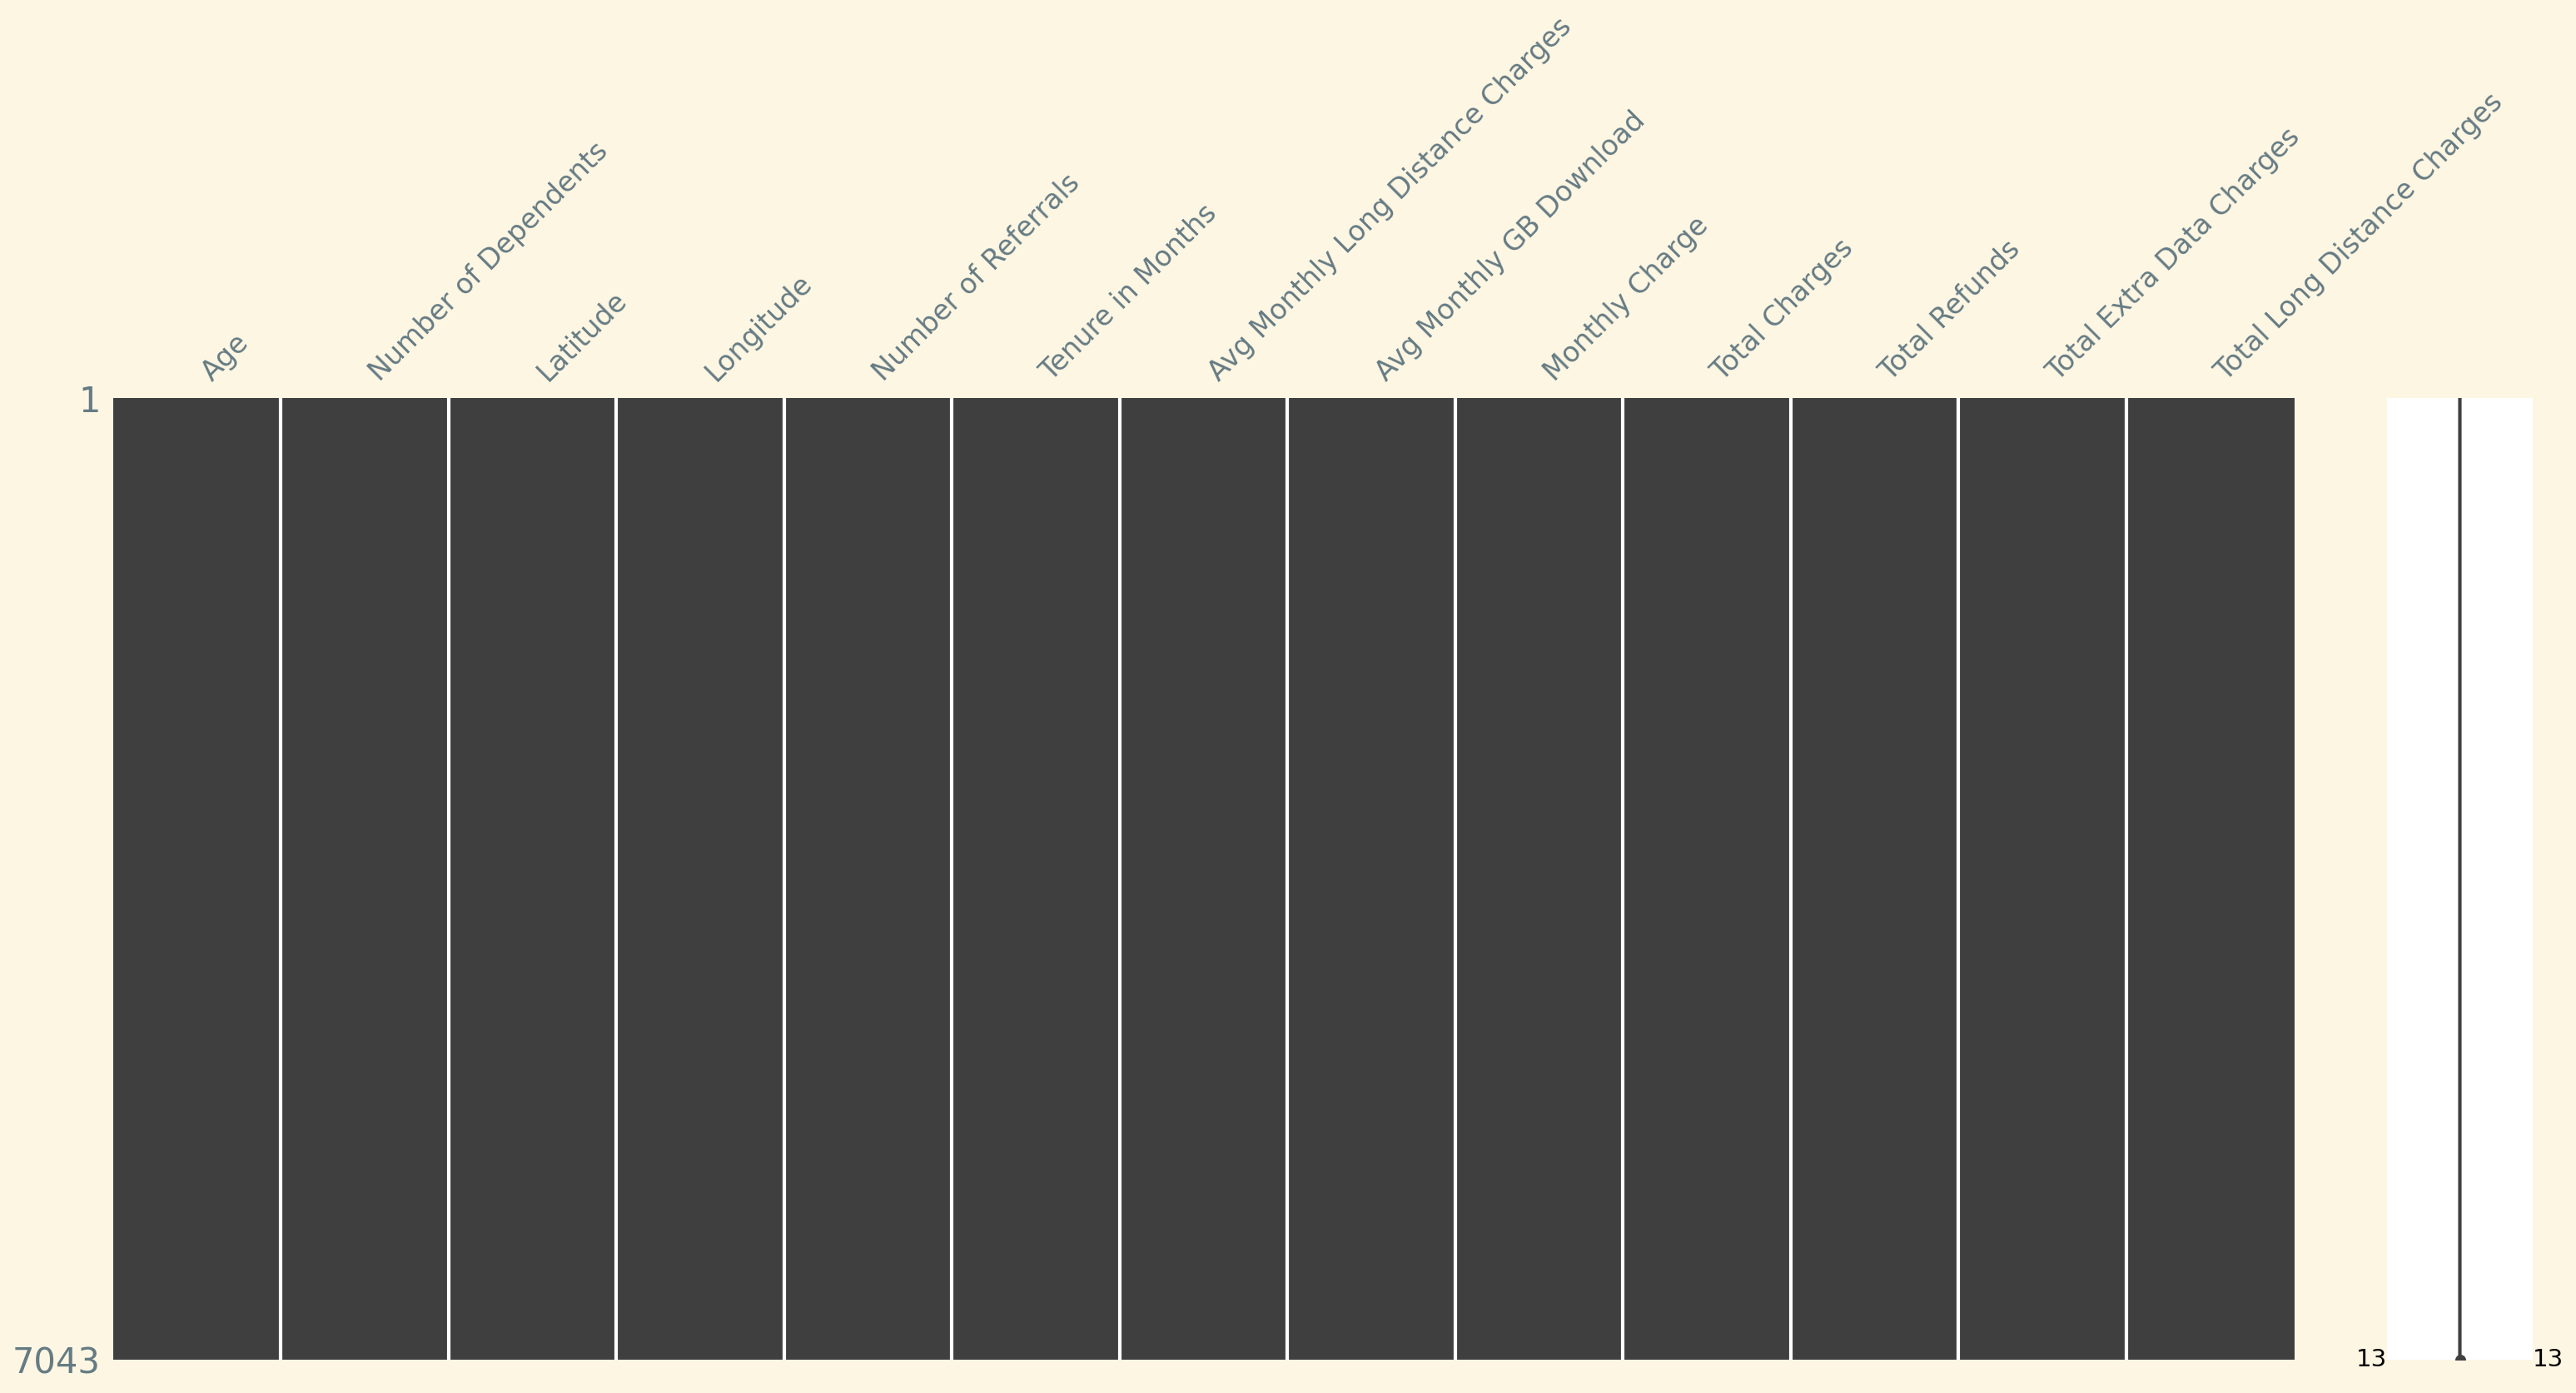

In [ ]:
# checking null values
msno.matrix(df2)
print("null values in numerical features:\n",df2.isna().sum())

# Model Training without PCA

In [ ]:
df = df2.join(df1_imputed)

In [ ]:
X = df.drop(['Customer Status'], axis=1)
y = df.loc[:, 'Customer Status'].values

In [ ]:
# Split Data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Scaling with StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Anomaly Detection

In [ ]:
'''
# First method: Isolation Forests
ifor = IsolationForest(max_features=25, n_estimators=100,
                       random_state=np.random.RandomState(42),
                       contamination=0.05, warm_start=True)
y_train_pred = ifor.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask = y_train_pred != -1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# First method: Isolation Forests\nifor = IsolationForest(max_features=25, n_estimators=100,\n                       random_state=np.random.RandomState(42),\n                       contamination=0.05, warm_start=True)\ny_train_pred = ifor.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask = y_train_pred != -1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [ ]:
'''
# Second method: Local Outlier Factor
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_train_pred = LOF.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# Second method: Local Outlier Factor\nLOF = LocalOutlierFactor(n_neighbors=20, contamination=0.05)\ny_train_pred = LOF.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [ ]:
'''
# third method: Elliptic
EE = EllipticEnvelope(contamination=0.05, random_state=42)
y_train_pred = EE.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# third method: Elliptic\nEE = EllipticEnvelope(contamination=0.05, random_state=42)\ny_train_pred = EE.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [ ]:
# fourth method: One Class Support Vector Machine
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
y_train_pred = ocsvm.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]

## Model Selection: SVM

In [ ]:
# GridSearch to determine the best hyperparameter in the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()

# Instantiate the grid search model
grid_search_SVC = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_SVC.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search_SVC.best_params_
best_score = grid_search_SVC.best_score_

print(f"Best parameters in SVC: {best_params}")
print(f"Best cross-validation score in SVC: {best_score}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters in SVC: {'C': 100, 'kernel': 'linear'}
Best cross-validation score in SVC: 0.8282833987568082


In [ ]:
# using best estimator to make predictions on the test set
best_model_SVC = grid_search_SVC.best_estimator_

In [ ]:
# training ohase for best hyperparameter
start_tra = perf_counter()
best_model_SVC.fit(X_train_scaled, y_train)
end_tra = perf_counter()

In [ ]:
# print classification report and confusion matrix
y_pred = best_model_SVC.predict(X_test_scaled)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))


def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1


accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        265   19   89
1.0         38   59    0
2.0         99    0  840
accuracy = 0.826 
precision = 0.829 
recall = 0.826 
f1 = 0.827


In [ ]:
# Accuracy on Train
train_score_SVC = round(best_model_SVC.score(X_train_scaled, y_train), 2)
print("The Training Accuracy is: ", train_score_SVC)

# Accuracy on Test
test_score_SVC = round(best_model_SVC.score(X_test_scaled, y_test), 2)
print("The Testing Accuracy is: ", test_score_SVC)

#training time
train_time_SVC = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_SVC)

The Training Accuracy is:  0.84
The Testing Accuracy is:  0.83
train phase time:  51.1637


## Model Selection: Random Forest

In [ ]:
# GridSearch to determine the best hyperparameter in the RF model
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rfc = RandomForestClassifier(random_state=42)
grid_search_RF = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')


# Fit the grid search to the data
grid_search_RF.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search_RF.best_params_
best_score = grid_search_RF.best_score_

print(f"Best parameters in RF: {best_params}")
print(f"Best cross-validation score in RF: {best_score}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters in RF: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score in RF: 0.8398802843247287


In [ ]:
best_model_RF = grid_search_RF.best_estimator_

In [ ]:
start_tra = perf_counter()
best_model_RF.fit(X_train_scaled, y_train)
end_tra = perf_counter()

In [ ]:
# print classification report and confusion matrix
y_pred = best_model_RF.predict(X_test_scaled)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        218   26  129
1.0         39   58    0
2.0         52    0  887
accuracy = 0.825 
precision = 0.816 
recall = 0.825 
f1 = 0.818


In [ ]:
# Accuracy on Train
train_score_RF = round(best_model_RF.score(X_train_scaled, y_train), 2)
print("The Training Accuracy is: ", train_score_RF)

# Accuracy on Test
test_score_RF = round(best_model_RF.score(X_test_scaled, y_test), 2)
print("The Testing Accuracy is: ", test_score_RF)

#training time
train_time_RF = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_RF)

The Training Accuracy is:  1.0
The Testing Accuracy is:  0.83
train phase time:  1.3735


# Model Training with PCA

## Elbow chart for determining best n_component

In [ ]:
# PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5'),
  Text(5, 0, 'PC6'),
  Text(6, 0, 'PC7'),
  Text(7, 0, 'PC8'),
  Text(8, 0, 'PC9'),
  Text(9, 0, 'PC10'),
  Text(10, 0, 'PC11'),
  Text(11, 0, 'PC12'),
  Text(12, 0, 'PC13'),
  Text(13, 0, 'PC14'),
  Text(14, 0, 'PC15'),
  Text(15, 0, 'PC16'),
  Text(16, 0, 'PC17'),
  Text(17, 0, 'PC18'),
  Text(18, 0, 'PC19'),
  Text(19, 0, 'PC20'),
  Text(20, 0, 'PC21'),
  Text(21, 0, 'PC22'),
  Text(22, 0, 'PC23'),
  Text(23, 0, 'PC24'),
  Text(24, 0, 'PC25'),
  Text(25, 0, 'PC26'),
  Text(26, 0, 'PC27'),
  Text(27, 0, 'PC28'),
  Text(28, 0, 'PC29'),
  Text(29, 0, 'PC30'),
  Text(30, 0, 'PC31'),
  Text(31, 0, 'PC32'),
  Text(32, 0, 'PC33'),
  Text(33, 0, 'PC34'),
  Text(34, 0

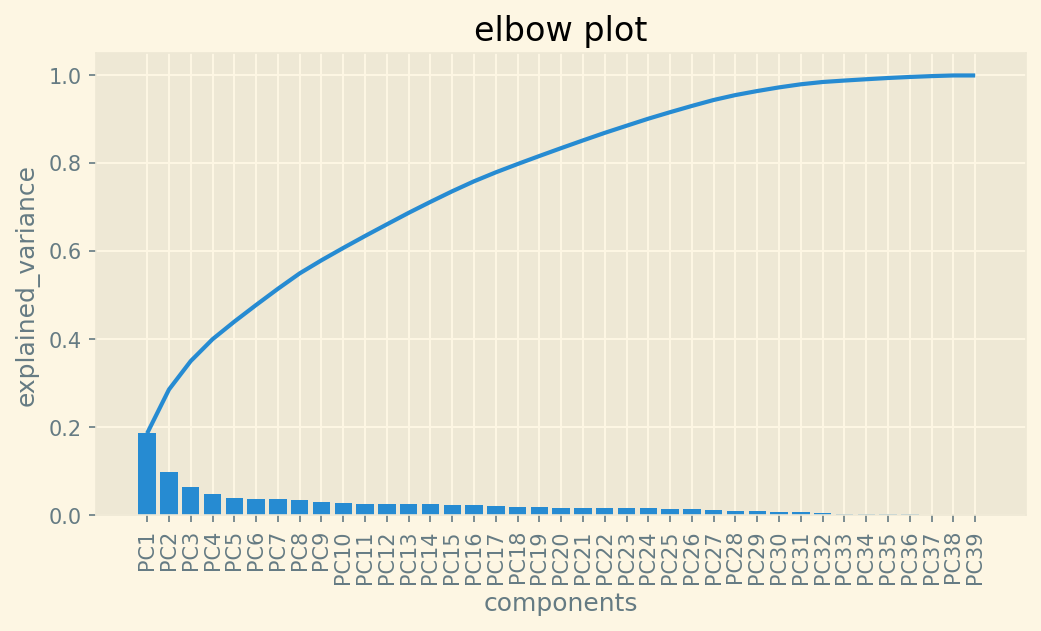

In [ ]:
# Determining best n_component for PCA
PC_list = ['PC'+str(i+1) for i in range(39)]

#plotting setup
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 150
plt.style.use('Solarize_Light2')


plt.bar(PC_list, pca.explained_variance_ratio_ )
plt.plot(np.cumsum(pca.explained_variance_ratio_ ))
plt.title('elbow plot')
plt.xlabel('components')
plt.ylabel('explained_variance')
plt.xticks(rotation=90)

In [ ]:
total_var = np.cumsum(pca.explained_variance_ratio_*100)

for i in range(39):
  print('PC{:2d}, explained_variance: {:0.2f}'.format(i+1, total_var[i]))

PC 1, explained_variance: 18.67
PC 2, explained_variance: 28.61
PC 3, explained_variance: 35.09
PC 4, explained_variance: 40.05
PC 5, explained_variance: 44.05
PC 6, explained_variance: 47.83
PC 7, explained_variance: 51.51
PC 8, explained_variance: 55.02
PC 9, explained_variance: 58.00
PC10, explained_variance: 60.80
PC11, explained_variance: 63.51
PC12, explained_variance: 66.16
PC13, explained_variance: 68.77
PC14, explained_variance: 71.27
PC15, explained_variance: 73.68
PC16, explained_variance: 75.94
PC17, explained_variance: 77.98
PC18, explained_variance: 79.87
PC19, explained_variance: 81.70
PC20, explained_variance: 83.49
PC21, explained_variance: 85.24
PC22, explained_variance: 86.95
PC23, explained_variance: 88.57
PC24, explained_variance: 90.18
PC25, explained_variance: 91.65
PC26, explained_variance: 93.08
PC27, explained_variance: 94.43
PC28, explained_variance: 95.55
PC29, explained_variance: 96.46
PC30, explained_variance: 97.29
PC31, explained_variance: 97.99
PC32, ex

n_component = ***16*** ==> 75% of information

In [ ]:
# PCA by n_components=28
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Model Selection: SVM

In [ ]:
# GridSearch to determine the best hyperparameter in the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()

# Instantiate the grid search model
grid_search_SVC_PCA = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_SVC_PCA.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search_SVC_PCA.best_params_
best_score = grid_search_SVC_PCA.best_score_

print(f"Best parameters in SVC: {best_params}")
print(f"Best cross-validation score in SVC: {best_score}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters in SVC: {'C': 1, 'kernel': 'rbf'}
Best cross-validation score in SVC: 0.7869407167148964


In [ ]:
best_model_SVC_PCA = grid_search_SVC_PCA.best_estimator_

In [ ]:
# training ohase for best hyperparameter
start_tra = perf_counter()
best_model_SVC_PCA.fit(X_train_pca, y_train)
end_tra = perf_counter()

In [ ]:
# print classification report and confusion matrix
y_pred = best_model_SVC_PCA.predict(X_test_pca)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        246   11  116
1.0         48   27   22
2.0         76   16  847
accuracy = 0.795 
precision = 0.783 
recall = 0.795 
f1 = 0.787


In [ ]:
# Accuracy on Train
train_score_SVC_PCA = round(best_model_SVC_PCA.score(X_train_pca, y_train), 2)
print("The Training Accuracy is: ", train_score_SVC_PCA)

# Accuracy on Test
test_score_SVC_PCA = round(best_model_SVC_PCA.score(X_test_pca, y_test), 2)
print("The Testing Accuracy is: ", test_score_SVC_PCA)

#training time
train_time_SVC_PCA = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_SVC_PCA)

The Training Accuracy is:  0.82
The Testing Accuracy is:  0.79
train phase time:  0.8193


## Model Selection: Random Forest

In [ ]:
# GridSearch to determine the best hyperparameter in the RF model
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rfc = RandomForestClassifier(random_state=42)
grid_search_RF_PCA = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')


# Fit the grid search to the data
grid_search_RF_PCA.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search_RF_PCA.best_params_
best_score = grid_search_RF_PCA.best_score_

print(f"Best parameters in RF: {best_params}")
print(f"Best cross-validation score in RF: {best_score}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters in RF: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score in RF: 0.7869435091657314


In [ ]:
best_model_RF_PCA = grid_search_RF_PCA.best_estimator_

In [ ]:
start_tra = perf_counter()
best_model_RF_PCA.fit(X_train_pca, y_train)
end_tra = perf_counter()

In [ ]:
# print classification report and confusion matrix
y_pred = best_model_RF_PCA.predict(X_test_pca)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        232   17  124
1.0         41   25   31
2.0         72   13  854
accuracy = 0.789 
precision = 0.773 
recall = 0.789 
f1 = 0.778


In [ ]:
# Accuracy on Train
train_score_RF_PCA = round(best_model_RF_PCA.score(X_train_pca, y_train), 2)
print("The Training Accuracy is: ", train_score_RF_PCA)

# Accuracy on Test
test_score_RF_PCA = round(best_model_RF_PCA.score(X_test_pca, y_test), 2)
print("The Testing Accuracy is: ", test_score_RF_PCA)

#training time
train_time_RF_PCA = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_RF_PCA)

The Training Accuracy is:  0.99
The Testing Accuracy is:  0.79
train phase time:  6.5233


# Conclosion

In [ ]:
Conclusion = pd.DataFrame({'Models':['SVM', 'RF', 'SVM + PCA', 'RF + PCA'],
                          'train acc'               :[train_score_SVC,train_score_RF, train_score_SVC_PCA, train_score_RF_PCA],
                          'test acc'                :[test_score_SVC, test_score_RF,  test_score_SVC_PCA,  test_score_RF_PCA],
                          'training time'           :[train_time_SVC, train_time_RF,  train_time_SVC_PCA,  train_time_RF_PCA]})

Conclusion

,Models,train acc,test acc,training time
0,SVM,0.84,0.83,51.1637
1,RF,1.00,0.83,1.3735
2,SVM + PCA,0.82,0.79,0.8193
3,RF + PCA,0.99,0.79,6.5233


#Reference
[Telecom Customer Churn Prediction in kaggle](https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics)